# Analysis of Belle2 MonteCarlo Data
### Laboratory for Computational Physics - Modul B

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)
- [Stack Overflow](https://stackoverflow.com/)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

The goal of this project is to find the branching ratio of 
$B^0 \rightarrow \eta' K_S^0$

with $\eta' \rightarrow \eta \; \pi^+ \pi^-$, 
$\eta \rightarrow \gamma \gamma$ and 
$K_S^0 \rightarrow \pi^+ \pi^-$
in Monte Carlo simulation (Data Challenge)

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the Data Challenge

In [1]:
import os, sys, pprint
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import joblib

In [2]:
Testing = True # Uses only a small subset of the data and trains on fewer epochs. 
PCA_ON = False
Local_Philipp = True
Local_Valeria = False
VM = False

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

For testing purpose only a small number of events are used
Paths are set to be run on Philipps Computer


## 1. Reading and Cleaning Data

In this chapter we
- read relevant information from root files into pandas data frames
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    print('Please set path for VM here')
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal", memory(Signal))
print ("Memory used by Continuum", memory(Continuum_bkg))
print ("Memory used by Peaking", memory(Peaking_bkg))

Welcome to JupyROOT 6.16/00


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


71.3 Mb
Memory used by Signal None
77.18 Mb
Memory used by Continuum None
0.49 Mb
Memory used by Peaking None


### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of backround

In [6]:
#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print(Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print(Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print(Peaking_bkg.shape)

#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print(Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

(213579, 85)
(120103, 85)
(933, 85)
(212354, 85)
212354


## 2. Data Preprocessing

In this chapter we
- label our data
- turn the label into one-hot vectors as this format is needed by Keras
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) to assure to have a fair amount of each type in all sets
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the principal components necessary for 99% of the variance

In [7]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [8]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)

Using TensorFlow backend.


In [10]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)

Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print(X_Train.nbytes/(1024 ** 2), "Mb")
print(X_Validation.nbytes/(1024 ** 2), "Mb")
print(X_Test.nbytes/(1024 ** 2), "Mb")
n_classes = Y_Train.shape[1]


#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

(166694, 83)
(100017, 83)
(66679, 83)
52.77863311767578 Mb
31.667369842529297 Mb
21.111896514892578 Mb


In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

joblib.dump(ss, 'Scaler.pkl')

['Scaler.pkl']

### PCA
PCA is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. 
The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise. 

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

if PCA_ON : 
    pca = PCA(n_components=len(Training))
    pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

    T50, T90, T95, T99, = False, False, False, False
    for i in range(len(pca.explained_variance_ratio_)) : 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
            print(str(i+1) + ' variables explain 50% of the variance')
            T50 = True
            n_50 = i + 1 
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
            print(str(i+1) + ' variables explain 90% of the variance')
            T90 = True
            n_90 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
            print(str(i+1) + ' variables explain 95% of the variance')
            T95 = True
            n_95 = i + 1
        if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
            print(str(i+1) + ' variables explain 99% of the variance')
            T99 = True
            n_99 = i + 1
        
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance')
    plt.show()
    joblib.dump(pca, 'PCA.pkl')
    
else : 
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation
    
    
pcTest.shape

(66679, 83)

In [13]:
# For input_dim chose n_50, n_90, n_95 or n_99 depending on how much explained variance we require
if PCA_ON : 
    input_dim = n_99
    pcTrain = pcTrain.iloc[:, 0:input_dim]
    pcTest = pcTest.iloc[:, 0:input_dim]
    pcValidation = pcValidation.iloc[:, 0:input_dim]
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced")

Input Dimension has not been reduced


## 3. Create the Neural Network 

In [14]:
optimizer = ['SGD', 'Adam']
epochs = [10, 30]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
if Testing : batch_size = [1000]
architectures = [ [50, 50], [50, 100, 50], [50, 100, 100, 50] ] 
if Testing : architectures = [ [50, 50] ]
activation = ['relu', 'elu']

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='relu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))

In [16]:
pcTrain.shape[1]

83

In [17]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=10000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [50, 50]


/home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
W0721 20:17:46.723863 140295770834752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 20:17:46.736934 140295770834752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 20:17:46.740183 140295770834752 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placehold

Epoch 1/2
166694/166694 [==============================] - 1s 6us/step - loss: 0.0554 - acc: 0.9228
Epoch 2/2
166694/166694 [==============================] - 1s 3us/step - loss: 0.0159 - acc: 0.9705
Layers:  [50, 50]
Best: 0.979609 using {'activation': 'elu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}
0.973526 (0.000951) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.971607 (0.001327) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.979501 (0.000178) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}
0.979261 (0.000797) with {'activation': 'relu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'Adam'}
0.973562 (0.000676) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'SGD'}
0.972363 (0.000927) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 1, 'optimizer': 'Adam'}
0.979609 (0.000270) with {'activation': 'elu', 'batch_size': 1000, 'epochs': 2,

Using TensorFlow backend.
W0721 20:17:12.617100 140228710889280 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 20:17:12.631345 140228710889280 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 20:17:12.632928 140228710889280 deprecation_wrapper.py:119] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 20:17:12.640817 140228710889280 deprecation.py:506] From /home/philipp/anaconda3/envs/Belle/lib/python3.7/site-packages/keras/backend/tensorflow_backen

In [18]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9796093460442156
{'activation': 'elu', 'batch_size': 1000, 'epochs': 2, 'optimizer': 'SGD'}


### Evaluate the best Network

In [19]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/2
166694/166694 [==============================] - 1s 6us/step - loss: 0.0623 - acc: 0.8956
Epoch 2/2
166694/166694 [==============================] - 0s 3us/step - loss: 0.0161 - acc: 0.9704


In [20]:
Best_Model.evaluate(pcTrain, Y_Train)

166694/166694 [==============================] - 2s 10us/step


[0.010269248947860852, 0.9814690390775913]

OMP: Info #250: KMP_AFFINITY: pid 28038 tid 28320 thread 7 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 28038 tid 28321 thread 8 bound to OS proc set 0


In [21]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

In [22]:
train_pred

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [23]:
train_prediction

array([[4.0079057e-03, 7.3626935e-03, 9.9198991e-01],
       [2.7589500e-03, 5.9747696e-04, 9.9944663e-01],
       [3.1174719e-03, 6.4626336e-04, 9.9962687e-01],
       ...,
       [2.0361990e-02, 4.4509768e-03, 9.9450469e-01],
       [3.0653179e-03, 4.0711761e-03, 9.9662328e-01],
       [2.3940742e-02, 3.8332809e-02, 9.6021420e-01]], dtype=float32)

In [24]:
N_true_peaking = 0
N_false_peaking = 0
for i in range(len(train_pred)) : 
    if Y_Train[i].all() == np.array([1,0,0]).all() : 
        if train_pred[i].all() == Y_Train[i].all() : N_true_peaking += 1
        else : N_false_peaking += 1
        
print ("Accuracy = ", N_true_peaking/(N_true_peaking + N_false_peaking))
print ("N_true_peaking: ", N_true_peaking)
print ("N_false_peaking: ", N_false_peaking)

Accuracy =  1.0
N_true_peaking:  166694
N_false_peaking:  0


In [25]:
print(Best_Model.evaluate(pcTrain, Y_Train))
print(Best_Model.evaluate(pcValidation, Y_Validation))

166694/166694 [==============================] - 2s 12us/step
[0.010269248947860852, 0.9814690390775913]
100017/100017 [==============================] - 1s 10us/step
[0.010227587359926259, 0.9813531699611067]


In [26]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Accuracy =  0.9813531699611067
N_true:  98152
N_false:  1865


In [27]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

166694/166694 [==============================] - 2s 9us/step
Trainig Error :  0.01853096092240869
100017/100017 [==============================] - 1s 11us/step
Validation Error :  0.018646830038893336


In [28]:
y_score = Best_Model.predict(pcValidation)
for s in y_score : 
    print(s)

[0.01343137 0.00753835 0.99224865]
[9.0834498e-04 1.1596978e-03 9.9922812e-01]
[0.01476413 0.02514651 0.9814477 ]
[1.0105789e-02 9.9985743e-01 1.5157461e-04]
[0.00553203 0.00296056 0.99745536]
[5.5916607e-03 9.9996459e-01 1.4066696e-05]
[0.00203958 0.00128496 0.99862087]
[0.01541388 0.00293514 0.997985  ]
[1.5518069e-04 2.6144385e-03 9.9678624e-01]
[0.00936872 0.00502422 0.9942899 ]
[2.2248626e-03 9.9994260e-01 2.5600195e-05]
[0.00826252 0.02906156 0.9722787 ]
[0.0101321  0.00957406 0.9933053 ]
[0.00341541 0.01040971 0.9959876 ]
[0.0096038  0.98843217 0.00730059]
[0.00529078 0.9977695  0.00125676]
[0.01749545 0.9935254  0.00423086]
[0.03014374 0.01516837 0.9894218 ]
[0.00395203 0.00321668 0.99741876]
[0.01321495 0.01287949 0.9895122 ]
[2.1427721e-02 9.9928808e-01 5.0601363e-04]
[3.2892823e-04 9.9967253e-01 7.6234341e-05]
[0.02358297 0.02822262 0.9789804 ]
[0.01996908 0.8749523  0.11865559]
[0.01671088 0.9985043  0.00122029]
[4.2935908e-03 9.9970925e-01 2.1451712e-04]
[0.00570253 0.0019

[0.02687544 0.83285    0.13088542]
[0.02089381 0.012328   0.9906859 ]
[0.01685345 0.00486675 0.9964738 ]
[0.00776058 0.6266274  0.3214196 ]
[0.01571736 0.02299091 0.9838077 ]
[0.01261577 0.548471   0.4573918 ]
[0.02106041 0.00479037 0.99510527]
[0.00739479 0.01887843 0.97455525]
[0.01001361 0.00562036 0.9959296 ]
[9.353757e-04 8.955598e-04 9.995676e-01]
[0.0120309  0.00594848 0.99694914]
[6.8583786e-03 9.9907756e-01 4.4775009e-04]
[0.01243395 0.01694807 0.98003066]
[2.2294223e-03 6.2125921e-04 9.9947453e-01]
[0.01601109 0.00938371 0.9907204 ]
[0.00461352 0.9088789  0.09367812]
[1.4002353e-02 9.9995643e-01 4.7534704e-05]
[0.01149571 0.00953093 0.99390006]
[0.00525281 0.00752208 0.99248147]
[2.7501583e-03 9.9981189e-01 1.4051795e-04]
[0.01105842 0.9977442  0.00125292]
[0.02713674 0.28166473 0.713078  ]
[6.4043999e-03 9.9999809e-01 1.2814999e-06]
[0.00177225 0.01198605 0.99463046]
[0.00336489 0.97881293 0.0243592 ]
[0.00749505 0.00848621 0.9956329 ]
[0.01742834 0.00714907 0.99129605]
[0.0

[1.5984178e-03 9.9996054e-01 4.8488379e-05]
[1.486069e-02 9.996269e-01 1.771748e-04]
[8.217335e-03 9.999218e-01 2.926588e-05]
[0.01729262 0.98979706 0.00390363]
[6.6810846e-04 9.9938017e-01 4.8613548e-04]
[0.02062708 0.0246267  0.9710151 ]
[0.00939232 0.08534655 0.90198016]
[2.6503205e-04 3.1673908e-04 9.9970508e-01]
[0.01180527 0.02497736 0.98138046]
[0.00908524 0.01928279 0.9799223 ]
[0.01673999 0.01078692 0.9896323 ]
[0.00809988 0.00522217 0.9966359 ]
[0.02237502 0.01387757 0.9852263 ]
[1.07290745e-02 9.99449015e-01 4.39316034e-04]
[0.0084675  0.92134184 0.06387773]
[6.21840358e-03 9.99785185e-01 1.08748674e-04]
[0.01153359 0.00697595 0.9943112 ]
[2.808839e-03 9.998951e-01 5.969405e-05]
[3.7674010e-03 9.9998474e-01 7.6293945e-06]
[0.00232849 0.5116891  0.4406989 ]
[0.00998536 0.02890229 0.9650035 ]
[0.00957978 0.00519353 0.9976492 ]
[0.00428277 0.00120723 0.9990282 ]
[0.00219101 0.00148261 0.9988482 ]
[4.8450828e-03 9.9984628e-01 1.1733174e-04]
[4.047364e-03 9.999257e-01 5.310774e-0

[1.4403135e-02 9.9987745e-01 4.8190355e-05]
[0.00652426 0.00242239 0.99820423]
[0.01419398 0.00896707 0.99178433]
[0.00517002 0.00340691 0.9962965 ]
[0.00870487 0.00559637 0.9926037 ]
[0.01855049 0.00720039 0.993935  ]
[0.00287595 0.00109017 0.99956703]
[0.01604652 0.9540386  0.03624257]
[0.02523038 0.02120671 0.9804915 ]
[1.1263639e-02 9.9998677e-01 3.2871962e-05]
[0.00762179 0.00392705 0.99688745]
[1.5863776e-04 2.0211935e-04 9.9995357e-01]
[0.031791   0.01749164 0.98404145]
[0.0140411  0.00515705 0.9929818 ]
[4.6303570e-03 9.9975753e-01 6.7442656e-05]
[0.00481433 0.01306394 0.9873897 ]
[6.0161948e-03 9.9969566e-01 5.7160854e-05]
[2.053678e-03 6.606877e-04 9.994509e-01]
[1.2523532e-02 9.9929738e-01 9.8130107e-04]
[0.03061104 0.993767   0.00555822]
[0.00562969 0.0052253  0.99603355]
[0.00847679 0.00719619 0.9941704 ]
[1.3118058e-02 9.9948394e-01 1.7678738e-04]
[0.00178942 0.20355415 0.8569076 ]
[0.01628271 0.9921316  0.00648066]
[0.00528619 0.00115293 0.9993583 ]
[3.9375722e-03 9.9870

[1.8954009e-02 9.9961555e-01 2.7468801e-04]
[5.7331622e-03 9.9998927e-01 1.0877848e-05]
[0.02604493 0.01281172 0.9853925 ]
[6.1553121e-03 9.9928451e-01 2.5892258e-04]
[0.01406455 0.0214535  0.98406947]
[0.00974992 0.01193771 0.99304336]
[0.00266957 0.00259951 0.99786735]
[0.02328667 0.08805102 0.9261452 ]
[0.02015468 0.0092276  0.9910515 ]
[0.01145798 0.9974986  0.00175634]
[0.01248792 0.972869   0.02208927]
[1.7596185e-03 8.7380409e-04 9.9922156e-01]
[2.4123013e-02 9.9976850e-01 3.0127168e-04]
[4.3606460e-03 9.9948043e-01 3.2436848e-04]
[0.00867003 0.00146475 0.99853724]
[0.01326519 0.9925469  0.00652099]
[0.00833136 0.01257858 0.995136  ]
[0.0089137  0.05104083 0.95664686]
[0.01107085 0.98985976 0.00544557]
[6.3578188e-03 9.9947053e-01 3.5521388e-04]
[8.159339e-03 9.998747e-01 5.596876e-05]
[5.6105852e-04 1.2817979e-04 9.9992347e-01]
[0.01243851 0.0243912  0.97759235]
[0.0236932  0.00837696 0.99190605]
[0.0060733  0.9973866  0.00131249]
[0.00389746 0.00801823 0.9918766 ]
[0.02137619 

[0.00915137 0.02260947 0.98366153]
[7.982552e-04 7.012725e-03 9.956839e-01]
[9.5480680e-04 4.3799579e-03 9.9281394e-01]
[0.02825814 0.06876943 0.94150704]
[2.8294027e-03 5.7950616e-04 9.9952590e-01]
[0.00388378 0.99543095 0.0022893 ]
[0.04848811 0.05193248 0.9466647 ]
[9.641707e-03 9.999299e-01 5.003810e-05]
[0.0066641 0.0017961 0.998603 ]
[0.03606629 0.99282885 0.00359401]
[2.3311317e-02 9.9934328e-01 5.9804320e-04]
[0.00664261 0.00282767 0.9980187 ]
[0.00134417 0.96154857 0.03073457]
[0.01083732 0.00563809 0.99699855]
[0.00764883 0.00152192 0.99887174]
[0.01469266 0.0103673  0.98963845]
[0.00660533 0.00157648 0.99857515]
[0.00927454 0.01178753 0.9930922 ]
[0.00458664 0.00905696 0.9941921 ]
[0.00940987 0.98490167 0.0038406 ]
[6.3527226e-03 9.9668932e-01 6.8557262e-04]
[0.01481304 0.9986886  0.00116077]
[0.00632396 0.00568736 0.9964096 ]
[0.03109685 0.00890416 0.9951712 ]
[0.01300114 0.9844277  0.0126861 ]
[1.1213720e-03 6.5696239e-04 9.9962187e-01]
[2.8435916e-02 9.9935114e-01 5.32090

[0.0117707  0.851201   0.11243707]
[0.01227364 0.00521407 0.9970655 ]
[0.04551569 0.00797287 0.9930849 ]
[0.00717387 0.00191829 0.99851453]
[0.02474612 0.01793253 0.9864452 ]
[2.9027462e-03 9.9997360e-01 1.6778708e-05]
[0.00568718 0.00330213 0.9983224 ]
[0.02574319 0.95579195 0.04453856]
[0.01612508 0.01507047 0.9919319 ]
[0.01394123 0.00976083 0.99259067]
[1.2028813e-03 7.1275234e-04 9.9960744e-01]
[0.04482996 0.06575665 0.92866147]
[0.00451347 0.00692964 0.99362576]
[0.01636326 0.99185306 0.00529855]
[6.9430172e-03 9.9950683e-01 3.3089519e-04]
[0.00863966 0.03173992 0.97605324]
[0.01683012 0.99387383 0.00544247]
[0.0241096  0.9841229  0.01431099]
[0.00678599 0.06816715 0.9191973 ]
[0.01843163 0.00909609 0.9886004 ]
[0.00352538 0.01728791 0.9895045 ]
[0.01981747 0.02616799 0.98042274]
[0.01086104 0.02204669 0.97809917]
[0.01921457 0.01559907 0.986472  ]
[3.9267540e-03 9.9993753e-01 3.3825636e-05]
[0.00543261 0.00884637 0.99153423]
[1.38524175e-02 9.99864578e-01 1.35868788e-04]
[0.0067

[0.01574162 0.01038957 0.9885969 ]
[2.4201304e-02 9.9936426e-01 6.1857700e-04]
[1.4300644e-03 9.9995184e-01 5.6296587e-05]
[0.00429398 0.0025017  0.99697626]
[0.05712286 0.9981824  0.00134927]
[0.0036208  0.7628704  0.23102897]
[0.00214848 0.96805286 0.03789023]
[0.00601995 0.99576503 0.00371122]
[0.00735095 0.00784445 0.9936887 ]
[0.00828004 0.00151563 0.99902165]
[0.00787151 0.00417969 0.99548304]
[0.01352659 0.04509926 0.9555255 ]
[0.02797702 0.06508264 0.94030774]
[0.02007994 0.02087724 0.98336065]
[0.00279838 0.00270888 0.99834526]
[1.7771125e-04 2.6640296e-04 9.9992311e-01]
[0.02351952 0.02960309 0.97503257]
[0.01300994 0.00836983 0.9908476 ]
[0.00490105 0.00230968 0.997602  ]
[5.4388046e-03 9.9884909e-01 8.4629655e-04]
[0.02615535 0.34312657 0.70901674]
[0.03919801 0.16136193 0.8158102 ]
[1.5115142e-03 4.3013692e-04 9.9975669e-01]
[0.0158734  0.02129763 0.97656274]
[5.4083169e-03 9.9996334e-01 2.0235777e-05]
[1.0273457e-03 9.9770212e-01 8.2531571e-04]
[0.01881129 0.99889386 0.00

[0.01728353 0.04531056 0.97123253]
[0.01380116 0.00939354 0.99702466]
[0.0043771  0.00127703 0.9995891 ]
[0.03705889 0.06051183 0.9450648 ]
[0.00451422 0.00299716 0.9978861 ]
[0.01105985 0.01089343 0.99043155]
[5.4478645e-05 2.1469593e-04 9.9986047e-01]
[3.2796502e-02 9.9879718e-01 8.1291795e-04]
[0.00480369 0.05776569 0.95811516]
[0.01065779 0.07666823 0.9185243 ]
[5.7076812e-03 9.9941885e-01 1.8712878e-04]
[0.01252475 0.00283733 0.9978516 ]
[0.0024848  0.03250578 0.96940684]
[0.00598338 0.00371838 0.99719095]
[0.04257056 0.03718361 0.9679567 ]
[0.00659698 0.00866073 0.9952454 ]
[0.00792474 0.15120366 0.82632387]
[0.00989228 0.11496466 0.9103142 ]
[0.00933322 0.00152603 0.9987761 ]
[0.02067879 0.00887057 0.99186313]
[0.0059627  0.00436175 0.9971478 ]
[0.01192659 0.04522547 0.9691329 ]
[0.00769418 0.00234222 0.99820507]
[0.01945496 0.00963098 0.98906493]
[0.0083732  0.00611463 0.99502504]
[0.01279318 0.9524661  0.04089087]
[0.00998268 0.04366052 0.9483144 ]
[0.00567359 0.00103056 0.999

[0.01184428 0.01404786 0.9900304 ]
[0.01602149 0.01034075 0.9935589 ]
[7.0938170e-03 9.9981827e-01 2.1284819e-04]
[7.2671771e-03 9.9971342e-01 1.3974309e-04]
[1.6033947e-03 9.9990427e-01 7.9184771e-05]
[0.01728737 0.0156455  0.99358904]
[0.00775144 0.00630149 0.9946923 ]
[0.01329651 0.83879375 0.18217888]
[0.00596729 0.9831437  0.02544865]
[0.00526837 0.00607929 0.99404067]
[1.1256337e-03 9.9928486e-01 5.0419569e-04]
[1.02644265e-02 9.99947965e-01 2.01463699e-05]
[0.0176211  0.00551844 0.99489355]
[7.0300400e-03 9.9978369e-01 1.4707446e-04]
[0.01707962 0.00586632 0.9953946 ]
[1.1066198e-02 9.9939698e-01 1.4460087e-04]
[0.02299511 0.3695618  0.61925054]
[0.08703488 0.8512012  0.16125354]
[0.00958982 0.35694945 0.6236171 ]
[0.00471759 0.00336063 0.9977083 ]
[0.01019946 0.999146   0.00122353]
[7.937580e-03 9.999130e-01 5.298853e-05]
[0.00421095 0.00119579 0.9990485 ]
[0.01069868 0.00838897 0.99460435]
[0.0150488  0.01271856 0.986827  ]
[4.2113662e-03 9.9835753e-01 5.3948164e-04]
[0.007593

[0.00782049 0.00707796 0.9953253 ]
[0.01614171 0.40243912 0.66314334]
[0.013731   0.00626633 0.99087024]
[0.00576469 0.0071632  0.99256015]
[0.01122016 0.00382531 0.99591845]
[1.9111633e-03 9.9962908e-01 3.9982796e-04]
[0.00354835 0.0016613  0.99952674]
[1.4660954e-03 3.6221743e-04 9.9981076e-01]
[1.4886528e-02 9.9796563e-01 7.1489811e-04]
[1.8105865e-02 9.9876595e-01 6.1425567e-04]
[0.02823699 0.01920432 0.990442  ]
[0.00283951 0.00242424 0.99853504]
[0.01442572 0.01784918 0.98703426]
[7.3304474e-03 9.9968237e-01 1.5041232e-04]
[1.2505859e-02 9.9936122e-01 3.5172701e-04]
[0.0144586  0.08725592 0.94029367]
[0.00466061 0.05446935 0.9475837 ]
[0.01456472 0.006641   0.9929328 ]
[1.7740130e-03 4.9334764e-04 9.9961841e-01]
[1.2846500e-02 9.9935186e-01 5.6016445e-04]
[0.0284344  0.9905423  0.00828066]
[2.1428168e-03 9.9994349e-01 3.1381845e-05]
[0.00971898 0.00376192 0.9962888 ]
[0.01400968 0.92954874 0.05813047]
[1.4125437e-02 9.9882281e-01 6.5869093e-04]
[0.00642091 0.83571076 0.23225948]


[0.009431   0.01236358 0.990811  ]
[0.0155752  0.06585246 0.9253434 ]
[0.01121238 0.09420002 0.9279566 ]
[3.4680963e-04 4.9266219e-03 9.9505067e-01]
[0.01527756 0.00561011 0.9965507 ]
[0.00417718 0.00139159 0.9991628 ]
[0.00858513 0.01063594 0.987576  ]
[8.3625317e-04 1.3580263e-02 9.9318534e-01]
[0.01302347 0.00863281 0.9909143 ]
[0.01485318 0.9638037  0.02114967]
[0.02236557 0.06414405 0.92552483]
[0.01887316 0.99102974 0.00892067]
[7.1668029e-03 9.9967593e-01 1.8203259e-04]
[2.6741028e-03 9.9999762e-01 9.2387199e-07]
[0.03206694 0.9959184  0.00291297]
[0.01128313 0.00410798 0.99469036]
[0.0042026  0.01113993 0.98161197]
[0.0122126  0.0018895  0.99856144]
[1.2094915e-02 9.9859393e-01 4.6008825e-04]
[0.00252324 0.9806837  0.02197415]
[0.02296141 0.02140874 0.9746482 ]
[0.00297338 0.96879476 0.01641381]
[5.4479241e-03 9.9999189e-01 5.5134296e-06]
[0.01178282 0.02770779 0.9782011 ]
[1.7087758e-03 3.0836463e-04 9.9985868e-01]
[0.01231998 0.753075   0.14920023]
[0.01520437 0.22688329 0.72

[0.03840154 0.99487096 0.00225878]
[0.0159016  0.9955443  0.00197685]
[6.8349838e-03 9.9922895e-01 4.6119094e-04]
[0.00398076 0.00869057 0.99281216]
[0.00461429 0.00367576 0.99797124]
[6.2285066e-03 9.9997306e-01 8.6426735e-06]
[0.0133163  0.02335063 0.98051697]
[0.0110606  0.9990002  0.00124922]
[0.01141864 0.03526351 0.97621953]
[0.01514125 0.06783509 0.92576253]
[0.01369381 0.0294117  0.96973383]
[0.02904603 0.01619372 0.9890978 ]
[0.00505432 0.04015648 0.96955764]
[0.00802049 0.00209042 0.99826515]
[1.9157022e-02 9.9981332e-01 8.3297491e-05]
[0.03115276 0.9981261  0.00143829]
[1.790288e-02 9.989647e-01 6.197393e-04]
[0.00717589 0.00399929 0.99764806]
[3.68279219e-02 9.99785125e-01 1.19805336e-04]
[0.01267534 0.00491545 0.9941083 ]
[0.0057891  0.00444052 0.996734  ]
[0.01906168 0.9981978  0.00218612]
[4.5423508e-03 9.9911261e-01 3.8194656e-04]
[1.1323154e-02 9.9983722e-01 1.6298890e-04]
[0.00397852 0.00393975 0.99798214]
[0.00151902 0.00120318 0.9993895 ]
[7.4927211e-03 9.9996793e-0

[0.01451248 0.90805495 0.07603157]
[5.4767728e-04 9.9947053e-01 2.8565526e-04]
[0.00922233 0.01371655 0.9879856 ]
[0.05566683 0.9824141  0.02089858]
[1.2038350e-03 2.8836727e-04 9.9979025e-01]
[9.3200803e-03 9.9998605e-01 1.1354685e-05]
[0.0180665 0.0261113 0.9783003]
[0.01019689 0.03175336 0.9793189 ]
[0.02883977 0.01331297 0.98757637]
[2.0792186e-03 9.9984431e-01 4.6432018e-05]
[0.00569576 0.00356978 0.9953774 ]
[0.01051432 0.0049119  0.9964825 ]
[1.0215193e-02 9.9990523e-01 4.3720007e-05]
[0.02165863 0.0137341  0.98717296]
[0.00474995 0.00225696 0.99858373]
[0.00641629 0.952229   0.04101464]
[0.02192956 0.01290584 0.9916666 ]
[0.02058849 0.00998527 0.9888698 ]
[0.00365594 0.00722119 0.9907763 ]
[3.9082766e-04 3.3270121e-03 9.9877155e-01]
[1.3528824e-02 9.9932635e-01 2.0053983e-04]
[0.01900962 0.3611749  0.6780045 ]
[0.02068114 0.01218373 0.99115896]
[0.01597074 0.00946346 0.9916668 ]
[0.00516626 0.00111821 0.99923223]
[6.0310364e-03 9.9984419e-01 5.5044889e-05]
[0.01461744 0.7383526

[0.03398249 0.04666549 0.95434684]
[0.00460425 0.9773083  0.01392886]
[0.02392188 0.05582875 0.9599954 ]
[3.7438571e-03 9.9999321e-01 4.4107437e-06]
[2.0600617e-02 9.9969280e-01 3.3426285e-04]
[0.00700951 0.00289464 0.99761266]
[0.01311862 0.0099135  0.9897538 ]
[0.00332576 0.00465271 0.9953373 ]
[0.00997156 0.63688344 0.43647215]
[0.00100136 0.00393483 0.99854726]
[0.03472149 0.00655487 0.9934574 ]
[0.00327849 0.99408334 0.0039956 ]
[0.01341093 0.14348549 0.86910784]
[0.01233086 0.00855568 0.98842394]
[0.01087043 0.98412037 0.00576231]
[0.01910791 0.9969255  0.0026094 ]
[5.3479075e-03 9.9993932e-01 6.9707632e-05]
[3.1622946e-02 9.9885565e-01 8.1038475e-04]
[7.828504e-03 9.999344e-01 4.452467e-05]
[3.0929744e-03 9.9982834e-01 1.3881922e-04]
[0.0116317  0.00240085 0.9975462 ]
[0.00377652 0.00296474 0.99810416]
[0.02046475 0.9609326  0.00951913]
[0.00698242 0.03791347 0.9748325 ]
[0.02972367 0.01982626 0.9843496 ]
[4.088998e-03 9.997442e-01 9.804964e-05]
[0.0063372  0.00204593 0.99900705

[0.00181547 0.07411659 0.9404602 ]
[0.0157263  0.43627143 0.5628167 ]
[0.01783764 0.01846272 0.98506725]
[1.22671425e-02 9.99917090e-01 6.78598881e-05]
[1.3084739e-02 9.9966228e-01 3.3885241e-04]
[0.02557844 0.7519938  0.16595781]
[0.00821334 0.05710012 0.95570374]
[3.9337873e-03 9.9995130e-01 4.3988228e-05]
[0.00708917 0.00553429 0.9951652 ]
[0.0054999  0.00402442 0.99467874]
[0.01245734 0.99637854 0.00482073]
[1.4864057e-02 9.9975395e-01 1.5437603e-04]
[4.3579638e-03 2.2682548e-04 9.9978846e-01]
[0.01051787 0.01815283 0.9852612 ]
[1.7787814e-03 2.2846460e-04 9.9981546e-01]
[0.00668916 0.01232648 0.988284  ]
[0.05581731 0.9854655  0.00926408]
[0.03233033 0.02263051 0.9827011 ]
[0.01611552 0.01542452 0.98100555]
[0.01644579 0.1323542  0.84966815]
[0.02424294 0.4936103  0.5031056 ]
[0.00362408 0.04014051 0.9508518 ]
[0.00692022 0.00211692 0.99884087]
[2.7142763e-03 9.2497468e-04 9.9953228e-01]
[1.4899164e-02 9.9989891e-01 6.0796738e-05]
[0.05063426 0.19590956 0.729827  ]
[0.01994652 0.2

[0.01128846 0.00394922 0.9959663 ]
[0.03688538 0.9719593  0.01735896]
[2.7532876e-03 9.9953246e-01 1.6754866e-04]
[0.01453194 0.02539206 0.97951496]
[0.00516781 0.00739759 0.99248505]
[0.00574315 0.0048247  0.99479   ]
[0.01524025 0.00880578 0.9934751 ]
[7.7267885e-03 9.9997663e-01 1.2695789e-05]
[3.9829642e-02 9.9866986e-01 9.3039870e-04]
[0.02535251 0.9961016  0.00411776]
[1.7576039e-02 9.9962270e-01 2.3058057e-04]
[9.581208e-03 9.996784e-01 6.377697e-05]
[0.01120859 0.99223423 0.00792754]
[0.03284112 0.00570786 0.99451315]
[3.2058358e-04 8.4473789e-03 9.8803419e-01]
[0.01689604 0.98347473 0.01207992]
[0.01302639 0.9830898  0.01361862]
[0.02655423 0.9927764  0.01047075]
[0.01811478 0.6533244  0.3298083 ]
[2.6360989e-02 9.9984539e-01 2.3502111e-04]
[8.9904964e-03 9.9902225e-01 5.5384636e-04]
[0.02549246 0.05104154 0.9584913 ]
[1.4426112e-03 9.9944133e-01 2.9924512e-04]
[0.0044646  0.00546041 0.987297  ]
[1.0250717e-02 9.9995935e-01 3.0785799e-05]
[0.00527382 0.00203156 0.9988791 ]
[0.

[0.01874733 0.98067844 0.01409864]
[7.9623461e-03 9.9994791e-01 3.5077333e-05]
[6.6806078e-03 9.9890679e-01 6.0909986e-04]
[0.00421241 0.9921403  0.00618193]
[0.0447287  0.02136689 0.981141  ]
[0.01317596 0.00363418 0.9958717 ]
[0.00902703 0.00409603 0.9952786 ]
[0.00718939 0.00713652 0.9957719 ]
[0.00828466 0.99752223 0.00135535]
[0.00812438 0.00670099 0.9929404 ]
[0.00466889 0.0024606  0.9977606 ]
[0.01146871 0.01475826 0.99065995]
[0.01686966 0.9973364  0.00136089]
[0.00908217 0.98054343 0.01104522]
[0.01323524 0.00398332 0.9970238 ]
[0.01373848 0.9985858  0.00156912]
[0.00843048 0.95419693 0.04765773]
[0.01231319 0.0192349  0.9845246 ]
[0.0065518  0.00416774 0.9976615 ]
[9.3692839e-03 9.9995553e-01 9.2506409e-05]
[0.01646903 0.00424483 0.99627244]
[0.00238726 0.95807433 0.01846948]
[0.02194971 0.01403734 0.98883235]
[0.01490572 0.03114116 0.9642143 ]
[0.00551125 0.9964439  0.00180995]
[0.00785357 0.18968269 0.7983606 ]
[0.01342651 0.00863552 0.9924921 ]
[0.01571357 0.14195964 0.871

[0.00693175 0.00184384 0.9987683 ]
[0.00560677 0.9763788  0.01283839]
[0.00476444 0.00843889 0.99426806]
[0.00587621 0.00807932 0.990553  ]
[0.01562858 0.9859214  0.00970179]
[6.3349009e-03 9.9989414e-01 6.1631203e-05]
[0.00398239 0.00121179 0.9991268 ]
[0.00892171 0.04952753 0.95146763]
[0.00106451 0.00156489 0.9988613 ]
[0.02672246 0.01491153 0.99127036]
[9.8038018e-03 9.9953926e-01 3.6281347e-04]
[0.00658628 0.00241807 0.9977255 ]
[0.01262477 0.9401535  0.04144445]
[0.03120604 0.99702287 0.00111362]
[0.01130849 0.0279521  0.978317  ]
[0.01338029 0.02609006 0.9797973 ]
[0.03140783 0.35348898 0.60890317]
[0.00539145 0.00379714 0.99840957]
[0.01200122 0.00976363 0.9898823 ]
[0.02313524 0.02419472 0.9708183 ]
[0.00851223 0.907729   0.08540294]
[0.0128122  0.00835422 0.9935272 ]
[0.0153355  0.04504243 0.97030103]
[0.00534245 0.00378194 0.9964253 ]
[0.01228705 0.00144097 0.9988168 ]
[0.00485483 0.03122023 0.9773046 ]
[0.00514394 0.00455326 0.9974463 ]
[0.0175795 0.0037235 0.9963033]
[9.89

[0.00161147 0.00105688 0.99928665]
[4.4497848e-03 9.9994278e-01 5.4061413e-05]
[7.1136653e-03 9.9999076e-01 8.9108944e-06]
[1.3225377e-03 5.9521198e-04 9.9972802e-01]
[0.04325503 0.01567188 0.9867808 ]
[0.00386137 0.00103736 0.9992784 ]
[0.00174591 0.11630324 0.8047308 ]
[0.01313338 0.99500084 0.00374341]
[0.00515056 0.12455907 0.8994851 ]
[0.01581392 0.01302546 0.9838178 ]
[0.01132405 0.02944449 0.97157776]
[0.00602815 0.00686562 0.9950005 ]
[0.00807494 0.01061967 0.9885677 ]
[1.9215435e-02 9.9951112e-01 1.8033385e-04]
[0.0054273  0.00254557 0.99815065]
[0.01936638 0.01358476 0.98871666]
[9.5739365e-03 9.9997747e-01 9.5963478e-06]
[0.00243402 0.03265017 0.94617903]
[4.9928129e-03 9.9996591e-01 2.6494265e-05]
[0.00388381 0.00524896 0.9937283 ]
[0.01429179 0.00758973 0.9944831 ]
[0.01034036 0.0081583  0.98918736]
[0.01850581 0.9566835  0.03973123]
[0.02240852 0.0074802  0.9949436 ]
[0.02619866 0.9801362  0.00971633]
[0.00795093 0.00336981 0.9968857 ]
[0.01658273 0.96813047 0.03840303]
[

[0.00588942 0.00348794 0.9975929 ]
[0.00587511 0.00516531 0.9958233 ]
[0.0143277  0.00299737 0.998592  ]
[5.7226121e-03 9.9971867e-01 2.9832125e-04]
[0.00535122 0.02033409 0.97748363]
[2.2889972e-03 9.6195936e-04 9.9930102e-01]
[0.03016996 0.03079817 0.9611512 ]
[8.999258e-03 9.998996e-01 6.240606e-05]
[0.00796133 0.02613556 0.9809276 ]
[0.02015796 0.95086837 0.05334601]
[0.01749629 0.02950493 0.9583545 ]
[1.2035102e-02 9.9962771e-01 4.2116642e-04]
[0.00333542 0.0239113  0.98508394]
[0.01523492 0.0082126  0.99351513]
[0.00892889 0.00354797 0.9963552 ]
[0.01704901 0.01963454 0.98603994]
[0.00147444 0.00314334 0.99715805]
[0.01648995 0.0032028  0.9971578 ]
[0.00568348 0.00214797 0.9992344 ]
[6.3189864e-04 5.3304434e-04 9.9966818e-01]
[0.00666428 0.9923858  0.00591907]
[0.01434267 0.00514036 0.9969515 ]
[0.00909674 0.98134446 0.01210529]
[0.01482728 0.00208965 0.9973167 ]
[0.01105782 0.02607015 0.96102935]
[4.0299892e-03 9.9996138e-01 1.5169382e-05]
[0.03008699 0.03671211 0.973777  ]
[0.0

[0.01369113 0.01797378 0.9848597 ]
[0.01554862 0.00483528 0.9971801 ]
[0.01079395 0.00288117 0.9979176 ]
[6.0588121e-04 9.9444461e-01 1.8877387e-03]
[0.01824585 0.0238764  0.9866334 ]
[0.02439952 0.01079839 0.98592955]
[0.00230762 0.00104898 0.9989853 ]
[1.9841820e-02 9.9954832e-01 4.8488379e-04]
[0.03815317 0.9708321  0.03149906]
[0.00592566 0.00234109 0.9975656 ]
[0.01368746 0.07896924 0.9190912 ]
[1.0760635e-02 9.9987912e-01 6.6220760e-05]
[0.00262707 0.27042502 0.6810671 ]
[2.0276934e-02 9.9916017e-01 4.3264031e-04]
[0.0135366  0.00405711 0.99671876]
[0.03161821 0.03399125 0.9778806 ]
[0.00869161 0.00251654 0.9977684 ]
[0.00340292 0.00455287 0.99766624]
[6.3950419e-03 9.9977422e-01 1.6251206e-04]
[0.0043698  0.00277442 0.9984399 ]
[0.01204494 0.01601878 0.9877605 ]
[0.01026466 0.04901412 0.9654026 ]
[0.03171256 0.9927956  0.00574803]
[0.0152885  0.9987327  0.00150234]
[0.01008585 0.00124884 0.99811554]
[0.00719178 0.9684066  0.0246295 ]
[0.00439405 0.99481034 0.00531203]
[0.0144772

[0.00528482 0.99601483 0.00447842]
[0.0173645  0.03075209 0.9768649 ]
[0.02137759 0.15933567 0.8459579 ]
[1.9604564e-03 9.9998528e-01 1.3649464e-05]
[0.01215881 0.00577202 0.99394643]
[5.5597425e-03 9.9998921e-01 1.5616417e-05]
[0.02113265 0.01454186 0.9847275 ]
[0.01330948 0.01364577 0.9882147 ]
[0.03612083 0.10157734 0.91838664]
[0.02300715 0.00968727 0.98926765]
[0.00557563 0.0087693  0.9903381 ]
[7.6956749e-03 9.9838644e-01 9.5459819e-04]
[0.00316215 0.00294653 0.9971717 ]
[0.03013822 0.04383564 0.96466565]
[0.00566682 0.00502688 0.9980464 ]
[0.01411688 0.00742555 0.9927281 ]
[0.00850582 0.00201908 0.9985276 ]
[0.001086   0.7159331  0.25504407]
[0.01703072 0.01359171 0.9872835 ]
[1.205802e-04 9.992745e-01 1.642406e-04]
[0.005615   0.01571718 0.98443776]
[0.00645235 0.00567982 0.99382806]
[8.5261166e-03 9.9975407e-01 1.0165572e-04]
[0.03726065 0.9498811  0.04415265]
[0.01144329 0.99837744 0.0019134 ]
[1.811713e-03 9.993332e-01 5.533397e-04]
[0.01564822 0.59934354 0.4078812 ]
[0.0754

[0.00188664 0.98332906 0.00802726]
[0.00677842 0.00643647 0.99518085]
[0.03004733 0.0133473  0.98995155]
[7.979870e-03 9.997856e-01 8.934736e-05]
[0.02604675 0.03957778 0.96798646]
[0.00172976 0.00395149 0.996992  ]
[4.1723251e-06 3.6022455e-01 3.8047320e-01]
[0.02394289 0.21033943 0.71677274]
[0.03409129 0.9978982  0.00155899]
[3.4458935e-03 2.9703975e-04 9.9978113e-01]
[0.00687519 0.05463186 0.94000125]
[0.00820288 0.0042448  0.9907913 ]
[6.4474940e-03 9.9997926e-01 1.9103289e-05]
[0.00770867 0.00822911 0.9927765 ]
[0.01562095 0.00161693 0.9991642 ]
[4.5576692e-04 2.2586137e-02 9.7310281e-01]
[0.02040309 0.00526494 0.9941797 ]
[0.01459473 0.01283011 0.98049873]
[2.1466017e-03 7.3599815e-04 9.9953008e-01]
[0.01906881 0.96268606 0.01200911]
[0.0198321  0.01169628 0.99152255]
[0.00539044 0.00950164 0.9921265 ]
[0.00189188 0.00110075 0.9992506 ]
[0.00958884 0.9970963  0.00143546]
[0.00819573 0.97270393 0.01407108]
[3.1939149e-03 3.6564469e-04 9.9977547e-01]
[7.2383583e-03 9.9930489e-01 2

[0.00610128 0.00175503 0.998371  ]
[1.0634840e-02 9.9975276e-01 1.2040138e-04]
[0.00128296 0.00438017 0.9974183 ]
[0.0122892  0.00493202 0.9967431 ]
[0.00982299 0.00306299 0.9975097 ]
[0.05396876 0.05444264 0.94766414]
[0.00208396 0.00106227 0.9986142 ]
[0.0113644  0.00436997 0.99299645]
[0.0260362  0.00575724 0.9957017 ]
[0.03036329 0.09208918 0.9184803 ]
[6.054431e-03 9.999770e-01 8.791685e-06]
[0.00256968 0.00173128 0.9980254 ]
[5.9738755e-03 9.9943000e-01 5.7590008e-04]
[0.00850797 0.9978276  0.00153628]
[0.01001197 0.006513   0.9929583 ]
[1.0734200e-03 6.5910816e-04 9.9949431e-01]
[0.01089373 0.01910967 0.98211604]
[0.01760638 0.00395557 0.9961433 ]
[3.4746528e-04 1.1882007e-02 9.9530017e-01]
[1.8224895e-02 9.9994516e-01 3.4511089e-05]
[0.00459406 0.00127044 0.9993157 ]
[0.01527631 0.9985773  0.0010564 ]
[2.5430322e-03 9.9995768e-01 3.2812357e-05]
[0.01095694 0.0037536  0.9959787 ]
[0.00968918 0.00542155 0.9963318 ]
[0.01328883 0.00848711 0.99468696]
[0.00496832 0.01314369 0.99306

[0.01538551 0.01119477 0.98298055]
[2.1432936e-03 5.6636333e-04 9.9956524e-01]
[0.02219278 0.6059051  0.30537   ]
[1.9675493e-04 9.9998277e-01 2.9474497e-05]
[0.01059869 0.00229624 0.9980094 ]
[0.01307371 0.00559649 0.9959878 ]
[0.00143623 0.00424561 0.99577665]
[0.0107443  0.01176932 0.9840739 ]
[0.01309025 0.91141224 0.04075807]
[7.866323e-03 9.999068e-01 5.298853e-05]
[0.01765528 0.0045847  0.9957905 ]
[0.0119018  0.21164602 0.78442794]
[0.01500252 0.98812294 0.00680614]
[0.01577902 0.9834111  0.01061666]
[0.01049691 0.9943408  0.00483602]
[1.9494891e-03 6.8056583e-04 9.9969041e-01]
[0.01141122 0.00779453 0.9899932 ]
[0.01890126 0.99490094 0.00314817]
[0.00924754 0.00470722 0.9968661 ]
[2.0748228e-02 9.9821639e-01 9.5307827e-04]
[1.4957368e-02 9.9944746e-01 1.8426776e-04]
[4.891306e-03 9.999256e-01 3.501773e-05]
[1.5073061e-02 9.9996239e-01 2.7388334e-05]
[9.4192326e-03 9.9984026e-01 7.1972609e-05]
[2.2128224e-03 5.1328540e-04 9.9972123e-01]
[0.02124879 0.9938741  0.00604644]
[0.008

[0.00793722 0.0317376  0.97141457]
[0.00202295 0.08382776 0.922311  ]
[0.01611349 0.01636922 0.9887928 ]
[0.01934525 0.00325692 0.9972805 ]
[0.00401393 0.00257927 0.9975023 ]
[0.02239558 0.00465891 0.99344134]
[1.8358231e-05 7.8395307e-03 9.9591184e-01]
[0.00297135 0.05682778 0.94204044]
[0.01229715 0.00686532 0.9957307 ]
[1.3280481e-02 9.9805719e-01 9.7930431e-04]
[0.00815198 0.87040275 0.12629467]
[1.1189610e-02 9.9884343e-01 6.3300133e-04]
[0.02732694 0.99756026 0.00221393]
[0.00432384 0.00164682 0.99893075]
[0.00539237 0.00178403 0.9988136 ]
[0.00142279 0.00112405 0.99920964]
[0.00993234 0.00273731 0.9988792 ]
[0.01393855 0.99694073 0.00145411]
[0.01256102 0.00655931 0.99130106]
[0.01011631 0.00284755 0.99704254]
[5.1975250e-05 3.5983324e-04 9.9981952e-01]
[4.8058927e-03 9.9997914e-01 8.1360340e-06]
[0.00857091 0.00236654 0.99834347]
[8.9285076e-03 9.9910587e-01 2.6506186e-04]
[0.00125912 0.07261813 0.86638004]
[0.00597203 0.00212562 0.9986849 ]
[0.         0.99647886 0.00142038]
[

[0.00172254 0.00730065 0.9949354 ]
[2.8306574e-02 9.9929696e-01 3.2702088e-04]
[0.00594476 0.00497511 0.99747646]
[0.00228283 0.9817157  0.00826764]
[0.01693082 0.07479933 0.9373226 ]
[0.00407219 0.00161076 0.9986174 ]
[0.0132969  0.00828102 0.99593854]
[1.3405472e-02 9.9979722e-01 1.6689301e-04]
[0.01618016 0.99571896 0.00467667]
[0.01082993 0.00376889 0.99833107]
[0.00884894 0.00535101 0.9957844 ]
[0.03061476 0.99892294 0.00174606]
[0.02174217 0.04561073 0.9597224 ]
[0.00281975 0.00269902 0.9985454 ]
[0.0082303  0.02685428 0.978773  ]
[0.04112419 0.9608463  0.02967727]
[1.2751460e-02 9.9968326e-01 2.0036101e-04]
[0.0033575  0.00600538 0.9960028 ]
[1.6643703e-03 2.0214915e-04 9.9992704e-01]
[2.8505027e-03 9.9824393e-01 8.8897347e-04]
[0.00745714 0.00481856 0.9965135 ]
[4.2994320e-03 9.9986756e-01 6.4432621e-05]
[6.8689585e-03 8.8337064e-04 9.9943638e-01]
[0.00610459 0.0031378  0.9974041 ]
[4.4373274e-03 9.9974298e-01 1.6629696e-04]
[3.5387278e-03 9.7662210e-04 9.9885660e-01]
[0.008276

[0.00521043 0.00878227 0.9918808 ]
[1.0238886e-03 3.3125281e-04 9.9985462e-01]
[1.5887916e-03 9.9911010e-01 3.2696128e-04]
[0.01695991 0.9756168  0.02510008]
[0.01713082 0.00940672 0.9941033 ]
[0.00540611 0.00237077 0.99762744]
[0.01588285 0.99025613 0.00687769]
[0.06537059 0.15977257 0.90469146]
[0.0152981  0.9978139  0.00130233]
[0.01204529 0.00385651 0.99748623]
[0.00998303 0.00350463 0.9967882 ]
[2.3299128e-02 9.9934602e-01 4.8509240e-04]
[0.01712558 0.00747484 0.9937252 ]
[0.0051097 0.0106428 0.993115 ]
[0.07688344 0.98265064 0.01312459]
[0.00404295 0.00230333 0.99852514]
[0.01421553 0.03063235 0.97029865]
[0.01639789 0.05405983 0.95165026]
[0.0024097  0.00208107 0.9977727 ]
[0.01152617 0.0185568  0.98819643]
[1.0310441e-02 9.9985075e-01 8.1300735e-05]
[0.01980129 0.0108313  0.99250156]
[0.02480838 0.99875325 0.00117612]
[0.00362456 0.06853679 0.9351902 ]
[0.01907626 0.9926307  0.00634834]
[0.01840228 0.98911273 0.01343638]
[0.01572397 0.00519881 0.9972269 ]
[0.02476063 0.9842876 

[0.00355038 0.00679597 0.9945178 ]
[0.02583593 0.03608471 0.9686936 ]
[0.02791652 0.00528604 0.99556553]
[0.008102   0.00740618 0.9953608 ]
[0.01003957 0.01525316 0.9840019 ]
[0.00621688 0.7791153  0.19799596]
[0.05207285 0.01480645 0.9872699 ]
[0.01191491 0.03543124 0.9778535 ]
[0.00479206 0.00606695 0.995589  ]
[0.00934497 0.16600668 0.8200823 ]
[0.0263474  0.27257323 0.6672326 ]
[0.00427568 0.006724   0.9943821 ]
[0.00543526 0.07311231 0.9340718 ]
[0.0077962  0.01738909 0.983186  ]
[9.2107356e-03 9.9980581e-01 2.4476647e-04]
[3.1418264e-02 9.9929416e-01 5.1009655e-04]
[0.04847261 0.02318874 0.97593534]
[0.01015562 0.01030102 0.99341357]
[0.02307281 0.02769068 0.9800117 ]
[6.1911345e-04 2.8210878e-04 9.9990249e-01]
[0.03592885 0.01251572 0.98472136]
[0.00924432 0.00617403 0.9944421 ]
[1.5586615e-04 1.7972720e-01 8.3684742e-01]
[6.872028e-03 9.998317e-01 2.129376e-04]
[0.00506192 0.00245816 0.99848485]
[0.00865099 0.99008036 0.00542995]
[0.00315252 0.01173767 0.9791639 ]
[0.00519714 0

[3.7639439e-03 9.9996901e-01 2.1010637e-05]
[0.01149482 0.00386041 0.9979087 ]
[3.5198033e-03 6.0087442e-04 9.9966764e-01]
[6.3510537e-03 9.9923337e-01 3.8969517e-04]
[0.0060378  0.00238594 0.99697447]
[0.00958544 0.0085527  0.9950675 ]
[0.03601977 0.02166641 0.9812196 ]
[0.00675163 0.00280479 0.9984454 ]
[0.01023141 0.0050329  0.9967203 ]
[0.01082599 0.00709021 0.9953239 ]
[0.02751726 0.99787104 0.00139949]
[5.662441e-07 5.006790e-05 9.999807e-01]
[0.03891402 0.03472954 0.9765321 ]
[0.007566   0.00216827 0.99898636]
[0.02772495 0.11385581 0.9008267 ]
[0.00302032 0.5897037  0.40540606]
[0.01462716 0.00454795 0.99689466]
[0.01024142 0.04896593 0.9362702 ]
[0.00341433 0.00154591 0.9985565 ]
[3.6060810e-06 9.9996042e-01 6.0915947e-05]
[0.01091853 0.00844377 0.9909097 ]
[7.3775053e-03 9.9998152e-01 1.1146069e-05]
[0.01061809 0.00353184 0.99710965]
[8.9240074e-04 9.9976516e-01 2.0268559e-04]
[0.00829509 0.897027   0.05454037]
[0.02731192 0.03143212 0.97987163]
[0.0103209  0.00913122 0.99302

[0.00676814 0.06396532 0.9209977 ]
[7.920355e-03 9.999159e-01 5.209446e-05]
[0.00642875 0.0185926  0.98542327]
[6.6755712e-03 9.9994421e-01 1.7881393e-05]
[0.00675389 0.06551409 0.9324013 ]
[3.9440393e-03 7.1200728e-04 9.9942720e-01]
[0.00406194 0.00542077 0.9956249 ]
[4.3459535e-03 9.9951923e-01 6.1589479e-04]
[0.01730335 0.08371574 0.8636601 ]
[0.0045265  0.00373292 0.99687046]
[0.00973791 0.0032858  0.99821216]
[0.03242841 0.02587524 0.97474825]
[0.01523602 0.00939527 0.9924756 ]
[5.6624413e-07 4.4433135e-01 2.4340275e-01]
[0.0083732  0.00619671 0.99600303]
[0.01456594 0.00168839 0.99829733]
[0.01155356 0.0041233  0.99714303]
[2.7168900e-02 9.9967563e-01 1.8975139e-04]
[0.02660027 0.89335686 0.11722636]
[0.01028153 0.0038631  0.996395  ]
[0.00243989 0.7611635  0.14673051]
[0.0110839  0.00491434 0.99762034]
[0.00270256 0.00207922 0.99885106]
[0.00559768 0.00519553 0.99432683]
[0.01196995 0.02507406 0.9825743 ]
[0.02270073 0.00826061 0.99178845]
[4.7234595e-03 9.9993825e-01 5.7697296e

[0.01261702 0.01147428 0.98565197]
[0.01437673 0.01131812 0.99138355]
[0.00164127 0.4216331  0.6670351 ]
[0.03407961 0.01539704 0.988075  ]
[0.02062398 0.9969035  0.00209695]
[0.00986469 0.00452694 0.9943193 ]
[8.5666180e-03 9.9963683e-01 1.6692281e-04]
[0.0052371  0.9993505  0.00104323]
[3.4018755e-03 8.1908703e-04 9.9879795e-01]
[0.00844982 0.9415667  0.04461658]
[0.00226164 0.00171897 0.9980781 ]
[5.2427053e-03 9.9932808e-01 5.2297115e-04]
[6.5268874e-03 9.9881721e-01 8.2659721e-04]
[0.01996893 0.00567862 0.9947913 ]
[3.9376915e-03 9.9996030e-01 4.9203634e-05]
[3.6263466e-04 1.9779801e-03 9.9795187e-01]
[0.00422639 0.01040077 0.9854428 ]
[0.00811875 0.9716357  0.04395589]
[0.0174745  0.99566764 0.00459313]
[0.0243746  0.01061809 0.99389505]
[7.3141158e-03 9.9998653e-01 9.2685223e-06]
[0.00642166 0.01111785 0.98558855]
[0.01652479 0.98894346 0.01082981]
[7.4461102e-04 8.7935328e-03 9.9333537e-01]
[0.00771186 0.9960363  0.00191003]
[0.01152462 0.02834466 0.9837779 ]
[0.01864493 0.0128

[0.00968882 0.5038471  0.40869462]
[0.00472796 0.0044103  0.99611914]
[0.00289458 0.1871469  0.8481543 ]
[3.8820505e-03 9.9947143e-01 2.5439262e-04]
[4.3338239e-03 5.8311224e-04 9.9967194e-01]
[0.01294023 0.9966879  0.00253144]
[0.01889306 0.05578455 0.963187  ]
[0.00987497 0.00179958 0.99850595]
[7.8266561e-03 9.9997598e-01 1.0579824e-05]
[0.0035007  0.00291169 0.99852777]
[0.03340819 0.9965111  0.00256127]
[1.46250725e-02 9.99790072e-01 7.22110271e-05]
[0.07605571 0.9833312  0.00603852]
[0.0115917  0.17501786 0.8950767 ]
[9.258896e-03 9.984831e-01 8.876920e-04]
[0.00191784 0.00114933 0.9992168 ]
[0.0084646  0.00520119 0.9938525 ]
[0.00943649 0.03633577 0.98068595]
[2.6739538e-03 7.3018670e-04 9.9924541e-01]
[1.3419539e-02 9.9946791e-01 5.9407949e-04]
[0.07924142 0.9697137  0.02397308]
[0.0042263 0.1418741 0.8818816]
[0.00870973 0.99698555 0.00101665]
[0.00944531 0.00682539 0.9954447 ]
[0.00537866 0.01774514 0.988112  ]
[0.00887185 0.9928613  0.00507072]
[0.0028024  0.00150731 0.99840

[0.02489549 0.02103254 0.9803299 ]
[3.4967065e-04 9.9671072e-01 7.8650117e-03]
[0.01712638 0.01130524 0.9889127 ]
[5.9675276e-03 9.9976420e-01 1.6424060e-04]
[8.7876320e-03 9.9988580e-01 1.0097027e-04]
[0.00466558 0.00118247 0.9987649 ]
[4.5254827e-03 9.9998045e-01 1.5109777e-05]
[0.0194813  0.94545054 0.0445208 ]
[1.2436509e-04 5.8415532e-04 9.9925643e-01]
[0.01151243 0.00929222 0.9918113 ]
[0.01139623 0.0064038  0.99603844]
[0.00478524 0.02967051 0.9832523 ]
[6.8673790e-03 9.9985945e-01 1.6790628e-04]
[9.5779002e-03 9.9950939e-01 2.6604533e-04]
[0.00684735 0.00514814 0.99571764]
[0.00898579 0.00439316 0.99713576]
[0.0167456  0.00744131 0.99352276]
[0.01311129 0.00372753 0.9974993 ]
[0.01194337 0.00377139 0.99603766]
[0.00691938 0.1411747  0.8287502 ]
[0.02942792 0.9969436  0.00268838]
[0.04889855 0.02372277 0.9661781 ]
[0.00788179 0.05123568 0.96050143]
[0.01809552 0.0041568  0.9969975 ]
[0.00128201 0.00311482 0.9994916 ]
[0.01014954 0.06051531 0.9404988 ]
[0.00353912 0.0065254  0.98

[0.00214788 0.00220433 0.99801064]
[9.1046989e-03 9.9980646e-01 1.7312169e-04]
[6.2180459e-03 9.9979067e-01 6.3866377e-05]
[0.00288048 0.00381315 0.9970336 ]
[8.269310e-03 9.992937e-01 5.699098e-04]
[8.4817410e-05 1.9478798e-04 9.9992108e-01]
[9.4412267e-03 9.9987864e-01 5.0038099e-05]
[0.00766981 0.9879254  0.00413427]
[0.00695738 0.0025872  0.99884284]
[2.0520866e-02 9.9950224e-01 3.0919909e-04]
[0.00476256 0.00169995 0.998814  ]
[2.1416247e-03 8.7562203e-04 9.9927723e-01]
[0.00257036 0.00781196 0.99423426]
[0.00569826 0.00579906 0.9940677 ]
[2.7273059e-02 9.9993044e-01 4.5508146e-05]
[0.00633958 0.99440694 0.00369218]
[0.01562566 0.0331127  0.9713495 ]
[0.00655144 0.00924987 0.99477684]
[0.0060145  0.0013932  0.99855256]
[0.01247728 0.00302356 0.99632907]
[0.01142997 0.02879864 0.98258966]
[0.01445234 0.00232026 0.9977133 ]
[1.8805832e-02 9.9656129e-01 9.3546510e-04]
[0.02127063 0.01582196 0.98685247]
[0.00371996 0.01075521 0.99314284]
[0.02209502 0.00887069 0.99294096]
[0.009379   

[3.3854514e-02 9.9871099e-01 6.3109398e-04]
[0.02549258 0.01067194 0.99141216]
[0.00620455 0.00338411 0.99694103]
[0.03342858 0.04396439 0.9520811 ]
[0.00852209 0.00740653 0.99525934]
[0.00416425 0.00371882 0.9970865 ]
[0.01351088 0.02040154 0.9807599 ]
[1.9026995e-03 3.1676888e-04 9.9979973e-01]
[3.8803518e-03 3.8909912e-04 9.9955851e-01]
[0.01143035 0.9927557  0.00747594]
[0.03116548 0.01211262 0.9869343 ]
[0.01522037 0.0065586  0.99681747]
[0.02546012 0.9987396  0.00168842]
[0.01204821 0.99571276 0.00390327]
[0.004013   0.05206424 0.9401717 ]
[0.00571838 0.96842253 0.02448508]
[0.0064114 0.0016101 0.9990284]
[0.00816151 0.00516921 0.99602044]
[0.00784197 0.02185288 0.9849256 ]
[0.02070037 0.03210345 0.9493456 ]
[0.01587561 0.05199417 0.9361217 ]
[1.8818378e-03 9.9951148e-01 1.8706918e-04]
[0.00908789 0.99687445 0.00328097]
[0.01049772 0.72125095 0.16685197]
[6.1692297e-03 9.9996293e-01 2.6613474e-05]
[2.8777122e-04 5.3890914e-02 9.2904711e-01]
[0.00257999 0.0022406  0.9982384 ]
[0.0

[0.0040803 0.0691824 0.948848 ]
[0.02817595 0.07524133 0.887244  ]
[0.01990271 0.05764151 0.9375391 ]
[0.00841954 0.00647944 0.99474525]
[0.00904021 0.02641934 0.97890043]
[4.3112040e-03 9.9994379e-01 4.5508146e-05]
[0.01007202 0.10410628 0.8723815 ]
[9.1916323e-03 9.9985403e-01 1.1959672e-04]
[0.00453719 0.00172558 0.99813724]
[0.00938237 0.97641826 0.01343808]
[0.00194052 0.00295517 0.99852717]
[0.01170096 0.01000661 0.9904605 ]
[0.02297717 0.9986974  0.00250259]
[0.01487797 0.02982226 0.9618922 ]
[0.01069596 0.11808786 0.8775939 ]
[0.00884789 0.00376868 0.996323  ]
[0.00876531 0.0014154  0.99905777]
[5.0151348e-03 9.9999404e-01 4.6491623e-06]
[0.00113317 0.15402555 0.78123164]
[0.00533405 0.9981204  0.00191656]
[3.6431253e-03 8.5580349e-04 9.9924213e-01]
[0.01640731 0.00715691 0.99577284]
[0.01833785 0.01089537 0.990929  ]
[3.6519766e-04 1.4255047e-03 9.9937689e-01]
[0.01862597 0.9820293  0.01767299]
[0.01279408 0.00444239 0.99594295]
[0.01803607 0.03697705 0.9497198 ]
[0.00504109 0

[0.00481433 0.00163057 0.9984669 ]
[0.00760469 0.01540893 0.98671126]
[0.01160911 0.01203507 0.98983276]
[0.03053722 0.03077993 0.985708  ]
[1.6676396e-02 9.9985957e-01 1.5383959e-04]
[0.01120117 0.9596243  0.04487672]
[0.01613158 0.9912591  0.00404793]
[0.01729718 0.9506929  0.02391249]
[0.01407376 0.00449663 0.9973862 ]
[0.01146486 0.01832852 0.9814484 ]
[0.00414869 0.98400563 0.01593596]
[0.00540122 0.00118473 0.99917984]
[2.3701966e-02 9.9960864e-01 4.2122602e-04]
[0.00334287 0.9960175  0.00265726]
[0.00214273 0.00265977 0.9968917 ]
[0.00710043 0.0060257  0.99620163]
[8.6684823e-03 9.9982476e-01 1.4263391e-04]
[0.00855529 0.00374895 0.9978969 ]
[6.3517690e-04 1.6562313e-02 9.7931612e-01]
[0.02549553 0.01115647 0.9913304 ]
[0.01453322 0.00360423 0.9974053 ]
[0.01203209 0.00565118 0.99113715]
[0.01757798 0.05502012 0.91425824]
[8.7779462e-03 9.9777710e-01 7.9640746e-04]
[4.5916766e-02 9.9981642e-01 3.7825108e-04]
[9.4619393e-04 3.2115281e-03 9.9458951e-01]
[2.5003850e-03 9.9996358e-0

[0.00232571 0.00232226 0.99876165]
[8.8900328e-03 9.9979150e-01 1.3944507e-04]
[0.01812243 0.9970175  0.00276047]
[1.5563071e-03 9.9955785e-01 5.0333142e-04]
[0.01784489 0.00867638 0.9917153 ]
[0.00310132 0.02288881 0.98413783]
[0.00885788 0.81351936 0.13628852]
[1.9420683e-03 6.1064959e-04 9.9950910e-01]
[3.3571124e-03 9.9999171e-01 5.3346157e-06]
[3.4146905e-03 2.3138523e-04 9.9981761e-01]
[8.8334084e-03 9.9933738e-01 2.2256374e-04]
[0.03291604 0.01610884 0.98035944]
[0.00629789 0.99789995 0.00146171]
[0.00216541 0.13281569 0.924225  ]
[0.02753165 0.99758995 0.00343698]
[0.01460937 0.98746145 0.0112474 ]
[0.00807759 0.00581235 0.99575603]
[1.2955219e-02 9.9939632e-01 3.9821863e-04]
[0.003326   0.00208631 0.9980337 ]
[1.2929708e-02 9.9927104e-01 3.8695335e-04]
[0.01265717 0.00167981 0.9988842 ]
[6.9712698e-03 9.9923813e-01 6.8572164e-04]
[0.02886027 0.08793044 0.9364944 ]
[0.00386757 0.00792342 0.9930147 ]
[1.6829669e-03 8.2439184e-04 9.9959850e-01]
[0.00635007 0.00214165 0.99830365]


[0.0148527  0.07530066 0.95935285]
[0.02034044 0.27805677 0.7551731 ]
[0.00368109 0.04400498 0.96457887]
[7.4330866e-03 7.5083971e-04 9.9918216e-01]
[0.00413868 0.00483856 0.9952341 ]
[0.00840116 0.07282501 0.9383687 ]
[0.01691696 0.02697933 0.9758177 ]
[0.00635788 0.9981147  0.00154525]
[0.00304726 0.00312886 0.9956343 ]
[0.02448276 0.01451591 0.9851432 ]
[0.00131708 0.00542888 0.9924041 ]
[0.00359845 0.00378662 0.9953457 ]
[0.01463017 0.00321373 0.99816513]
[0.01034579 0.00365853 0.99623215]
[0.01104337 0.00540119 0.99581206]
[0.00508761 0.9687742  0.01666346]
[0.01824299 0.986021   0.00911224]
[0.01383129 0.12466085 0.9219614 ]
[0.01016816 0.00835979 0.9852605 ]
[0.00666335 0.9954623  0.0038324 ]
[2.1356940e-03 2.4667382e-04 9.9987495e-01]
[0.01512244 0.00580969 0.99369514]
[0.0043146  0.00155491 0.99913025]
[7.0291758e-03 9.9872005e-01 9.6562505e-04]
[0.01188007 0.03514504 0.9701829 ]
[0.00383663 0.00299597 0.9980739 ]
[0.01892841 0.99711156 0.00203189]
[0.00648192 0.00620204 0.996

[0.00858146 0.00585642 0.9968337 ]
[0.01459178 0.07170412 0.9484168 ]
[0.00782555 0.00486967 0.9973024 ]
[0.00321707 0.03290984 0.9615791 ]
[2.8781891e-03 5.9872866e-04 9.9955207e-01]
[0.00738984 0.01751417 0.9744557 ]
[7.4172020e-04 2.9638410e-04 9.9983263e-01]
[0.01337793 0.00608259 0.9962395 ]
[1.3781786e-03 9.9960625e-01 1.7002225e-04]
[0.00808641 0.00627282 0.9944171 ]
[0.00519678 0.9895482  0.00336179]
[0.01042154 0.02285126 0.9823439 ]
[0.0085105  0.01397383 0.98980296]
[0.02291912 0.03012723 0.9691274 ]
[0.02230909 0.00444651 0.9962095 ]
[0.00610447 0.98383546 0.00937042]
[4.1601062e-04 7.2083664e-01 3.5883743e-01]
[0.01064143 0.00659811 0.9946196 ]
[0.00990614 0.02302772 0.9795171 ]
[0.00712675 0.00490844 0.9951484 ]
[5.1823556e-03 9.9991703e-01 6.5892935e-05]
[0.01327032 0.00820547 0.9903269 ]
[0.00747648 0.02711117 0.9704138 ]
[0.00558487 0.00423139 0.996986  ]
[0.00522766 0.01027876 0.98918426]
[8.7100267e-03 5.5494905e-04 9.9948859e-01]
[2.5089324e-02 9.9987662e-01 1.50352

[0.01171839 0.9875376  0.00923908]
[0.00214627 0.99470305 0.00373539]
[1.3060868e-02 9.9983299e-01 3.0899048e-04]
[0.00240961 0.8881646  0.09100449]
[0.00105473 0.00968963 0.9933065 ]
[0.00199586 0.90150905 0.0845086 ]
[0.01677424 0.01115343 0.9851687 ]
[0.01555824 0.01038554 0.993574  ]
[9.8838210e-03 9.9977463e-01 6.8932772e-05]
[0.00615221 0.00370061 0.99831593]
[0.00688338 0.00449041 0.9970968 ]
[9.5474720e-04 9.6474075e-01 6.6596568e-02]
[0.00980365 0.00233757 0.99855816]
[0.01186675 0.9987701  0.00167096]
[0.0062705  0.00275272 0.9969561 ]
[2.2777915e-04 9.9977040e-01 1.8528104e-04]
[0.00905326 0.01295897 0.9873446 ]
[0.01644647 0.991137   0.00246954]
[0.00445968 0.00423124 0.993929  ]
[0.00676873 0.00321922 0.99677324]
[0.02068841 0.02223432 0.98507816]
[5.0864816e-03 9.9998403e-01 9.6261501e-06]
[0.00845811 0.96555305 0.02316353]
[0.00626612 0.00924554 0.99289525]
[0.01360863 0.00840735 0.9942769 ]
[0.00932074 0.00261807 0.99856883]
[0.00939375 0.00627515 0.99274886]
[0.0297741

[0.00541854 0.3148918  0.74859935]
[2.2102535e-02 9.9985933e-01 1.7786026e-04]
[0.02794662 0.01159471 0.9851435 ]
[0.00893769 0.00529358 0.9975831 ]
[0.01335391 0.02398482 0.9869412 ]
[0.00122938 0.37056318 0.5201282 ]
[0.01779476 0.2663123  0.62542987]
[0.01382473 0.0106186  0.98786384]
[0.00624236 0.0025695  0.99826294]
[0.0057354  0.681625   0.43034858]
[0.00881553 0.04429457 0.9754282 ]
[0.02070946 0.97561634 0.01842681]
[2.7161241e-03 9.9894083e-01 6.0614944e-04]
[0.04877377 0.00527772 0.99519837]
[0.01367864 0.99147785 0.00616229]
[2.1362305e-04 9.9978614e-01 2.7689338e-04]
[0.01006797 0.00357723 0.99674094]
[0.01421571 0.95939183 0.04194018]
[0.01903078 0.99494296 0.00169247]
[0.00396061 0.00109923 0.9989717 ]
[0.00485587 0.00690511 0.99266136]
[0.00471836 0.00742048 0.9920157 ]
[0.02140722 0.00664046 0.99562323]
[6.1982870e-04 6.1702728e-04 9.9961615e-01]
[2.6104361e-02 9.9986291e-01 1.4087558e-04]
[0.01827982 0.9954063  0.0033313 ]
[0.00822791 0.9822114  0.01558444]
[0.0030981

[0.00693783 0.00529507 0.9941405 ]
[0.00385818 0.00462651 0.9940603 ]
[0.00643253 0.00822222 0.99317706]
[0.02512589 0.01889303 0.97675145]
[0.02072483 0.02278462 0.9818709 ]
[0.0104517  0.0068112  0.99343324]
[1.0442734e-04 9.9756336e-01 2.0417571e-03]
[0.01754868 0.03197432 0.95084715]
[0.01537251 0.0038321  0.9935932 ]
[0.011408   0.01410246 0.98408866]
[0.00669584 0.5473487  0.3669898 ]
[0.03909871 0.9948926  0.00226778]
[0.02167273 0.03374282 0.9737556 ]
[6.3844323e-03 9.9990630e-01 2.6464462e-05]
[0.02080825 0.00657892 0.99617636]
[0.00703812 0.00764519 0.99451876]
[0.0184488 0.007274  0.9933094]
[0.00271928 0.00282094 0.99894154]
[0.01786894 0.00828356 0.9884972 ]
[0.00555637 0.00743577 0.993793  ]
[0.01284948 0.01459795 0.99092066]
[0.01700085 0.00523666 0.9953097 ]
[0.00547072 0.00372991 0.9973949 ]
[9.4032586e-03 9.9924457e-01 2.2652745e-04]
[4.8741400e-03 9.9996614e-01 2.5987625e-05]
[0.00365448 0.00191155 0.99859   ]
[0.00563377 0.00233451 0.99842346]
[0.02376625 0.99816954

[0.01051527 0.04218    0.9455037 ]
[0.02718934 0.964382   0.01589686]
[0.01243976 0.00819436 0.9921665 ]
[0.00824022 0.05161828 0.9570098 ]
[0.00255629 0.9743696  0.01605994]
[0.00324047 0.002451   0.9979817 ]
[0.04023278 0.99801457 0.0018971 ]
[6.4096749e-03 9.6175075e-04 9.9877727e-01]
[0.01189786 0.00439939 0.99693   ]
[0.00726211 0.01064324 0.9875932 ]
[0.00492585 0.01422372 0.984349  ]
[8.1788898e-03 9.9994057e-01 5.8323145e-05]
[0.02445599 0.8834209  0.14314634]
[0.00196671 0.00159734 0.99925315]
[3.8821995e-03 9.9966174e-01 2.7784705e-04]
[0.01230928 0.00619915 0.99399316]
[0.00261769 0.0023441  0.9979805 ]
[0.02035183 0.7264582  0.2875685 ]
[0.00943905 0.02163294 0.97641784]
[0.00525504 0.0014869  0.99873334]
[1.3298392e-03 3.3009052e-04 9.9969524e-01]
[0.01834267 0.00550774 0.9922224 ]
[0.0053823  0.00869226 0.99064845]
[0.00234917 0.8159214  0.13741028]
[0.0139606  0.00203672 0.99863744]
[2.2053719e-06 9.9806231e-01 2.2272766e-03]
[0.00208685 0.00375408 0.997131  ]
[4.6533644

[0.01123813 0.00845128 0.9928062 ]
[7.6001585e-03 9.9974155e-01 2.0882487e-04]
[0.00661147 0.01030618 0.9914301 ]
[0.00181544 0.07679212 0.9593172 ]
[0.0128397  0.01285031 0.98677564]
[0.0065448  0.00952998 0.99356985]
[0.01961294 0.04608586 0.9544052 ]
[0.01952279 0.03371289 0.9677194 ]
[0.0079051  0.00687462 0.99373686]
[0.01871002 0.00550723 0.9943781 ]
[0.02284789 0.0287686  0.9769448 ]
[8.4229112e-03 4.7993660e-04 9.9979126e-01]
[8.8861287e-03 9.9978435e-01 7.2658062e-05]
[0.02601743 0.0706386  0.9539417 ]
[0.00910506 0.00617668 0.9920864 ]
[0.00840032 0.00590023 0.99682623]
[0.00496614 0.11198539 0.86849785]
[3.8636327e-03 9.9993259e-01 5.1915646e-05]
[0.00229427 0.2407377  0.7766406 ]
[0.01149458 0.99727464 0.00140724]
[0.00850517 0.00947675 0.9886861 ]
[0.03079998 0.99334145 0.00423968]
[0.02545744 0.00860843 0.99511814]
[4.4653416e-03 9.9998844e-01 7.3015690e-06]
[0.00907651 0.00603521 0.9972184 ]
[0.00708747 0.00556237 0.9949981 ]
[0.01453435 0.27083242 0.69487447]
[0.010225 

[0.00563067 0.01062635 0.9920192 ]
[0.03723738 0.01146743 0.9938494 ]
[0.01088217 0.99765337 0.00142542]
[7.1033835e-03 9.9978089e-01 1.1497736e-04]
[0.01136395 0.9958768  0.00271168]
[0.00461397 0.00172853 0.9986056 ]
[0.00507757 0.00661394 0.99495214]
[0.01455808 0.9941478  0.00484973]
[0.01648045 0.9990784  0.00172314]
[0.01768655 0.00688642 0.99260175]
[8.568734e-03 9.998585e-01 9.289384e-05]
[0.00347    0.00106481 0.9991654 ]
[0.01252836 0.00946543 0.9911853 ]
[4.2128563e-04 4.4962764e-04 9.9954379e-01]
[0.00733292 0.00598007 0.9962577 ]
[0.0044885  0.9882046  0.00279489]
[0.00824374 0.07433385 0.9418088 ]
[7.4282289e-04 1.4500916e-03 9.9860859e-01]
[0.00192723 0.987672   0.00844973]
[0.00972268 0.23722002 0.79381895]
[0.00300413 0.8541068  0.09952238]
[0.00740016 0.00513077 0.99332607]
[7.7561140e-03 9.9903631e-01 5.5783987e-04]
[2.9586852e-03 3.1507015e-04 9.9976361e-01]
[0.00263241 0.00146264 0.9989848 ]
[0.00133428 0.01357123 0.9805776 ]
[0.00350896 0.00262049 0.9978614 ]
[0.0

[0.00937611 0.00545749 0.9957329 ]
[0.00501117 0.00672945 0.9951936 ]
[2.2383243e-02 9.9957079e-01 3.3506751e-04]
[0.00960723 0.00914314 0.991086  ]
[0.01790255 0.9980614  0.00410226]
[0.00381833 0.00114301 0.9993403 ]
[0.0296829  0.00937864 0.98884904]
[9.0402961e-03 9.9984139e-01 1.5431643e-04]
[0.00819287 0.9557823  0.04142177]
[0.03811949 0.9939531  0.0125615 ]
[0.02201173 0.02266523 0.98476994]
[0.00579402 0.00255832 0.99785125]
[0.01556504 0.00765872 0.99306583]
[6.4393580e-03 9.9956787e-01 3.4815073e-04]
[0.01184359 0.00466377 0.99485683]
[0.00816631 0.00593457 0.9961866 ]
[0.01077133 0.00861952 0.9897196 ]
[0.01812288 0.9761133  0.01107025]
[0.00832266 0.01517645 0.98964256]
[1.4895499e-03 9.9999690e-01 1.5199184e-06]
[0.01017398 0.00202227 0.9983622 ]
[0.00288886 0.00254256 0.9982508 ]
[1.5372038e-04 4.3264031e-04 9.9979472e-01]
[5.4775774e-03 9.9996233e-01 2.8401613e-05]
[0.01397032 0.02161422 0.9857784 ]
[2.1426380e-03 9.9952453e-01 3.5136938e-04]
[1.4486611e-03 9.9985558e-0

[0.033544   0.04446426 0.95013905]
[6.2255561e-03 9.9986613e-01 1.0237098e-04]
[0.03304395 0.01427063 0.98722446]
[0.01285535 0.12839738 0.85058993]
[0.00155556 0.984282   0.007278  ]
[1.5378296e-03 1.5491247e-04 9.9989343e-01]
[0.00418702 0.9917918  0.00450712]
[0.00825542 0.00378594 0.997065  ]
[0.00951859 0.00530449 0.9962623 ]
[0.01023686 0.09098887 0.92563564]
[1.95822120e-03 9.99869525e-01 1.10805035e-04]
[0.00597191 0.00778124 0.9929907 ]
[0.01597765 0.10085252 0.91170913]
[0.00833488 0.99764824 0.00102472]
[0.02321947 0.01103023 0.9915259 ]
[0.00455716 0.41214484 0.6642647 ]
[0.02237579 0.3395512  0.6613818 ]
[0.01169336 0.9965158  0.00491482]
[0.00110862 0.01644436 0.9687513 ]
[0.083579   0.9834652  0.01631576]
[9.955794e-03 9.992702e-01 8.344054e-04]
[0.01196718 0.02112871 0.98238635]
[0.0330734  0.99323124 0.00522497]
[0.01334691 0.06811127 0.9277117 ]
[0.00799137 0.00527665 0.9971227 ]
[0.00159416 0.00122315 0.99843746]
[0.01076096 0.9931804  0.00290516]
[0.02001277 0.00849

[0.009801   0.01348919 0.9900358 ]
[0.         0.9861622  0.00227487]
[0.00995484 0.45398092 0.55073917]
[7.5020492e-03 9.9995327e-01 3.1173229e-05]
[0.0254088 0.01538   0.986267 ]
[0.00965157 0.00615424 0.9942725 ]
[0.01421049 0.00442213 0.9972594 ]
[0.00893462 0.01761702 0.98580074]
[7.119894e-03 9.999113e-01 7.995963e-05]
[0.01676461 0.00832531 0.9931232 ]
[0.02027842 0.97611606 0.02652028]
[8.0424547e-04 2.8164387e-03 9.9720871e-01]
[3.4919381e-04 1.4984608e-04 9.9977648e-01]
[0.00600851 0.00159493 0.9988142 ]
[8.2640052e-03 9.9945587e-01 4.5847893e-04]
[3.3576190e-03 9.9982262e-01 1.3530254e-04]
[3.3625841e-02 9.9944139e-01 4.5454502e-04]
[4.7569275e-03 9.9991387e-01 7.7575445e-05]
[2.2266805e-03 4.9346685e-04 9.9974781e-01]
[0.01849082 0.992761   0.00498909]
[0.00937241 0.02054    0.98324716]
[0.01295373 0.9957142  0.00555405]
[0.02383527 0.015596   0.9916736 ]
[0.05970529 0.9923736  0.01012281]
[5.7518482e-06 2.0369887e-04 9.9989855e-01]
[0.0036636  0.0010922  0.99923956]
[0.010

[0.01843989 0.01982921 0.9848969 ]
[0.01041391 0.01104665 0.9798353 ]
[0.00511947 0.00524813 0.9966904 ]
[6.3917637e-03 9.9996090e-01 4.1186810e-05]
[0.00320885 0.00186592 0.9984784 ]
[0.01341894 0.98731947 0.00814769]
[0.01569545 0.01160449 0.9930339 ]
[0.02694026 0.03576541 0.96500933]
[0.00479144 0.00136259 0.99915975]
[0.00691581 0.01404366 0.98383117]
[0.00364262 0.00399816 0.99841976]
[0.01800144 0.8916054  0.11277843]
[0.01704985 0.85304475 0.11815995]
[0.00615966 0.98908335 0.00384629]
[0.0046573  0.00243059 0.99805105]
[3.6480725e-03 9.9995017e-01 4.9442053e-05]
[0.00877693 0.00266328 0.9981291 ]
[0.01443002 0.01394597 0.99138844]
[0.00476009 0.99868083 0.00164741]
[4.0009916e-03 4.4044852e-04 9.9939430e-01]
[0.00277954 0.00109643 0.9995189 ]
[0.00083637 0.15604997 0.73790574]
[4.9358010e-03 9.9871266e-01 8.8900328e-04]
[0.0151273  0.00677744 0.9939681 ]
[0.00973091 0.9973011  0.0012266 ]
[0.0029299  0.00226945 0.99878424]
[0.00398657 0.0013257  0.99909836]
[0.00728968 0.01865

[0.00441402 0.00333428 0.99479526]
[6.2844157e-04 6.5211624e-02 9.4111311e-01]
[0.01002514 0.01898894 0.98683417]
[8.1395805e-03 9.9997556e-01 1.1712313e-05]
[0.01361054 0.01340979 0.9896065 ]
[0.00994304 0.00335294 0.9970689 ]
[9.217858e-05 2.284646e-03 9.951712e-01]
[0.01070246 0.00399753 0.9956547 ]
[0.00656667 0.9973235  0.00227964]
[1.48284435e-02 9.99907851e-01 7.06911087e-05]
[0.00940791 0.00794178 0.99454546]
[0.00956151 0.0072166  0.99276274]
[0.01798999 0.9944929  0.00641701]
[0.00114071 0.00518665 0.9944484 ]
[0.00969583 0.0065535  0.99502134]
[0.01128224 0.00540137 0.9944307 ]
[0.01646107 0.9951511  0.00398561]
[0.02463871 0.01265907 0.98969793]
[0.01273438 0.00654459 0.9946909 ]
[0.00911415 0.98421276 0.01577032]
[0.0101575  0.00451279 0.9960766 ]
[0.00280938 0.00417745 0.99530536]
[0.00697333 0.8885056  0.04589754]
[5.3644180e-07 9.9450350e-05 9.9970603e-01]
[1.6320765e-02 9.9887097e-01 6.4927340e-04]
[0.03271437 0.9910119  0.00686416]
[2.1115214e-02 9.9957335e-01 3.98755

[3.0280948e-03 9.9981195e-01 4.3034554e-05]
[0.02625111 0.52701753 0.58065647]
[0.004509   0.00170252 0.9986577 ]
[0.00556159 0.01828945 0.9825729 ]
[0.00635374 0.02562183 0.978355  ]
[0.00958335 0.19601083 0.8036343 ]
[0.01055482 0.00736365 0.99522674]
[0.00173932 0.00156495 0.9988142 ]
[0.01446456 0.00549111 0.9974748 ]
[0.00643927 0.00599885 0.99534774]
[9.7694993e-03 9.9986827e-01 1.1378527e-04]
[0.00410473 0.00186232 0.9988851 ]
[0.0087817  0.00430015 0.991725  ]
[7.6112747e-03 9.9994254e-01 5.5402517e-05]
[0.00720507 0.00241548 0.9988866 ]
[0.0105508  0.00409281 0.99699384]
[0.01233798 0.0192427  0.9817381 ]
[0.01455146 0.99733186 0.00144345]
[0.04984701 0.98968184 0.01255351]
[2.0855665e-04 1.6117394e-03 9.9914581e-01]
[0.00738406 0.00842926 0.9915094 ]
[1.2004942e-02 9.9991620e-01 7.8678131e-05]
[0.00503784 0.00557107 0.9966899 ]
[0.02185464 0.9953276  0.00298852]
[0.00381261 0.00138846 0.9989789 ]
[0.01944607 0.98627526 0.01006928]
[0.00721994 0.00153589 0.99905944]
[0.0283538

[0.04666293 0.17690957 0.8262205 ]
[0.02890265 0.13898054 0.87055457]
[0.01876619 0.00640735 0.99447805]
[0.01864088 0.999241   0.00122917]
[0.01817951 0.97822005 0.01100576]
[8.8036060e-04 1.2229383e-03 9.9964088e-01]
[7.1798265e-03 9.9994195e-01 2.9921532e-05]
[0.02034155 0.9871736  0.0127328 ]
[0.03600892 0.45157033 0.63690567]
[0.00281915 0.00194365 0.9987069 ]
[0.01168203 0.00660428 0.996382  ]
[0.00238651 0.00458324 0.9911005 ]
[0.00561664 0.00784725 0.99546105]
[0.01182058 0.9557103  0.05299711]
[0.00549379 0.99820197 0.0010266 ]
[4.2278171e-03 5.6895614e-04 9.9975264e-01]
[0.02320105 0.03684598 0.97675633]
[0.00431821 0.05357444 0.96207166]
[0.00557917 0.03117311 0.9662621 ]
[1.5658140e-04 5.1915646e-05 9.9997652e-01]
[0.0052467  0.00323141 0.9986623 ]
[0.01686367 0.00345352 0.9960884 ]
[1.8922687e-03 9.9998599e-01 6.7949295e-06]
[0.00133872 0.00813219 0.99313295]
[8.1047416e-03 9.9975598e-01 1.8706918e-04]
[0.01261544 0.02270696 0.98342794]
[0.03584629 0.02064344 0.98090535]
[

[0.00715682 0.00586271 0.99258375]
[0.01440051 0.02399325 0.9838271 ]
[0.00830382 0.05829623 0.93140197]
[0.02470526 0.9980945  0.00213113]
[0.00731403 0.00318095 0.9958831 ]
[4.2284429e-03 9.9982005e-01 4.4435263e-05]
[4.3161213e-03 4.8899651e-04 9.9963570e-01]
[0.01107988 0.00652269 0.9959421 ]
[0.01039624 0.0621818  0.94954157]
[3.2833815e-03 3.3050776e-04 9.9963212e-01]
[0.02196768 0.9872291  0.01820037]
[0.00580686 0.00144854 0.99863744]
[0.0037908  0.05324939 0.96580946]
[0.01129737 0.9860648  0.01035523]
[0.02164486 0.9988268  0.00146675]
[1.1992723e-02 9.9937570e-01 1.7279387e-04]
[2.7546287e-04 9.9618083e-01 3.0052960e-03]
[0.00463071 0.00136036 0.99887824]
[0.01409078 0.0459322  0.9461811 ]
[0.01805201 0.04820013 0.9455859 ]
[0.03151089 0.82381415 0.16341415]
[0.01035219 0.94411814 0.04348895]
[0.01352009 0.9969002  0.00198138]
[0.00497422 0.0367015  0.94412947]
[1.5016735e-02 9.9970722e-01 2.4044514e-04]
[0.01981169 0.99654055 0.0019215 ]
[0.01342556 0.9925349  0.00400266]
[

[0.01612189 0.04311135 0.9731587 ]
[0.00557506 0.04198396 0.9649549 ]
[0.01426402 0.00757486 0.9873992 ]
[8.7538362e-04 2.6804805e-02 9.6909046e-01]
[7.1975589e-04 1.1661947e-03 9.9896646e-01]
[0.02177727 0.9748     0.02157372]
[0.01215106 0.0235821  0.97815216]
[2.6137114e-02 9.9937510e-01 7.5706840e-04]
[0.0069516  0.00782222 0.99512005]
[0.03726318 0.02783781 0.97371066]
[0.01328993 0.9807265  0.01113638]
[0.00343084 0.00448385 0.9970004 ]
[0.00636649 0.2939719  0.6641067 ]
[0.01321349 0.97251785 0.02714428]
[0.01809198 0.99845606 0.0013313 ]
[0.01339895 0.99695015 0.00416955]
[0.01313457 0.0051797  0.99474406]
[1.2012273e-02 9.9975467e-01 1.1199713e-04]
[3.3086538e-04 9.9300849e-01 5.1853955e-03]
[0.04348877 0.15707472 0.8595507 ]
[0.01037264 0.97162116 0.02823868]
[0.01637176 0.01470327 0.9881195 ]
[1.2311786e-02 9.9918586e-01 4.1776896e-04]
[0.01006454 0.00667861 0.99666214]
[0.01723224 0.999037   0.00137588]
[0.03851002 0.99366987 0.00479594]
[0.0098744  0.00378743 0.9970368 ]
[

[0.00800338 0.00493944 0.9964677 ]
[9.8468065e-03 9.9991298e-01 3.3974648e-05]
[3.5392344e-03 9.9993801e-01 3.0755997e-05]
[1.5136778e-02 9.9975854e-01 2.8795004e-04]
[2.5919080e-03 9.1338158e-04 9.9907476e-01]
[0.03355289 0.01804644 0.98692125]
[0.0032551  0.00237867 0.9987866 ]
[2.5846660e-03 9.9976414e-01 1.2603402e-04]
[0.00740522 0.00209609 0.998271  ]
[0.04875734 0.99496037 0.00519639]
[0.00958571 0.00911108 0.9911575 ]
[1.0062456e-03 9.9994040e-01 4.4852495e-05]
[0.00883022 0.00929138 0.9934505 ]
[0.02177331 0.02082941 0.9819536 ]
[0.00256687 0.91584015 0.04496583]
[0.00127253 0.0956974  0.9325867 ]
[0.01728976 0.96045196 0.05518559]
[0.00143054 0.00240484 0.9989686 ]
[0.00861603 0.0031372  0.9975753 ]
[0.00821367 0.7912624  0.23505315]
[0.01118624 0.01298782 0.98574626]
[0.00519815 0.7089039  0.43447417]
[8.1824958e-03 9.9967957e-01 1.2958050e-04]
[0.00464997 0.00404033 0.99612385]
[0.00109223 0.00196493 0.9977942 ]
[8.2350969e-03 9.9928188e-01 1.8626451e-04]
[0.00259426 0.0063

[2.2044182e-02 9.9949002e-01 2.7188659e-04]
[8.6393952e-04 9.9898183e-01 7.6848269e-04]
[0.01266435 0.00388753 0.9985633 ]
[0.00419229 0.00555035 0.99407405]
[0.00954628 0.99811244 0.00195172]
[0.00868562 0.02220392 0.969224  ]
[0.0135833  0.9829457  0.01173747]
[0.00273892 0.03462222 0.97643614]
[0.00568515 0.00631851 0.99531746]
[0.00543234 0.00632629 0.9938155 ]
[0.00499761 0.04016563 0.97306335]
[0.01593587 0.02796841 0.9689871 ]
[6.7045093e-03 9.9915254e-01 9.7447634e-04]
[0.01674864 0.99604464 0.00219333]
[0.00468105 0.34563923 0.62868243]
[0.07172251 0.03719875 0.94474447]
[1.1217594e-04 9.9978113e-01 9.2566013e-05]
[1.1535823e-02 9.9842215e-01 6.4080954e-04]
[0.00414494 0.00167745 0.99894536]
[0.0186376 0.0654906 0.9370485]
[0.01747674 0.08371788 0.9129795 ]
[0.00309107 0.00308526 0.9970899 ]
[3.0459672e-02 9.9956942e-01 1.8998981e-04]
[0.03485614 0.1511086  0.87311906]
[0.0072521  0.9924023  0.00430617]
[0.01112595 0.00750443 0.99661016]
[1.5386820e-02 9.9985069e-01 2.7185678e

[0.00794798 0.00425801 0.99654484]
[0.00493085 0.00242093 0.99885607]
[0.01138431 0.01404011 0.98721015]
[0.00430134 0.00325218 0.99796677]
[8.5446537e-03 9.9992114e-01 1.0177493e-04]
[0.01187962 0.00110152 0.99884474]
[0.02817118 0.01094022 0.99284077]
[0.01067111 0.00449866 0.9975256 ]
[0.00803903 0.07655403 0.9082644 ]
[0.01268986 0.2084311  0.7980277 ]
[3.4566820e-03 4.8077106e-04 9.9967378e-01]
[1.9021332e-03 4.3189526e-04 9.9936944e-01]
[0.00468153 0.0043802  0.99676824]
[0.01138034 0.00352383 0.99697113]
[0.00338399 0.00252387 0.99836814]
[0.02230856 0.99765635 0.00158796]
[0.05857822 0.8789774  0.09108195]
[0.03425694 0.13411435 0.7803683 ]
[0.00774831 0.02671555 0.97669196]
[0.0015237  0.8746145  0.07895398]
[0.02324009 0.99104846 0.00552177]
[0.00239369 0.00144088 0.99930686]
[0.016137   0.00540733 0.9958077 ]
[3.6477745e-03 6.7180395e-04 9.9945712e-01]
[6.1869621e-05 1.0647476e-03 9.9945068e-01]
[0.02355528 0.03401309 0.9706799 ]
[0.00185075 0.01193807 0.99586624]
[0.0200462

[0.01428384 0.02310368 0.9791001 ]
[0.031427   0.01306215 0.98555475]
[0.03529298 0.0198783  0.98621356]
[0.00902382 0.0055207  0.9967438 ]
[0.00348055 0.00161538 0.998083  ]
[0.00336292 0.89078677 0.11415115]
[0.00501359 0.00181603 0.99896806]
[2.8675109e-02 9.9848306e-01 8.7371469e-04]
[0.00926852 0.00731227 0.99479926]
[7.4779987e-04 9.9718404e-01 8.2480907e-03]
[0.00728804 0.03253785 0.97574306]
[0.00805795 0.00239149 0.99857605]
[0.01374337 0.00483075 0.9961833 ]
[0.0046896  0.02757022 0.973311  ]
[0.01761398 0.03342572 0.96970785]
[4.24838066e-03 9.99927819e-01 1.04397535e-04]
[0.00879294 0.00185493 0.99816823]
[5.5556595e-03 9.9997663e-01 1.5765429e-05]
[0.00446758 0.9890324  0.00504693]
[2.2321135e-02 9.9989212e-01 7.6979399e-05]
[0.013861  0.0252094 0.9716376]
[0.00580427 0.00284818 0.9979826 ]
[0.01114747 0.61262554 0.32074457]
[0.01613888 0.5050776  0.44785413]
[0.03395382 0.8584118  0.11679927]
[0.00727487 0.00277901 0.9981605 ]
[0.00744972 0.98085856 0.01174274]
[0.0153449

[1.7660856e-04 2.3333132e-03 9.9699354e-01]
[0.008008   0.28545496 0.7409324 ]
[0.0279834  0.08119074 0.91522825]
[0.02844006 0.9635029  0.02910343]
[0.03201076 0.01441532 0.9932624 ]
[0.01605958 0.14821297 0.881287  ]
[0.01901221 0.01555258 0.9904873 ]
[1.2642145e-04 1.1594594e-03 9.9948221e-01]
[0.05662885 0.99880004 0.00116643]
[9.2751384e-03 9.9985254e-01 1.2922287e-04]
[0.01323861 0.00508446 0.99626756]
[0.02769285 0.04593027 0.9695163 ]
[9.6140504e-03 9.9998987e-01 9.0003014e-06]
[0.00414678 0.00427571 0.9972118 ]
[6.9755316e-03 9.9956840e-01 6.6232681e-04]
[0.01881972 0.00680745 0.9963438 ]
[0.01398146 0.01677236 0.9881122 ]
[0.00182974 0.99329376 0.0066767 ]
[0.02169883 0.00594273 0.99647117]
[1.3789833e-02 9.9975097e-01 1.4328957e-04]
[1.3128817e-03 9.9970841e-01 6.8157911e-05]
[0.00424662 0.00522292 0.9970087 ]
[2.6846826e-03 9.1528893e-04 9.9954581e-01]
[2.0677447e-03 3.7738681e-04 9.9970239e-01]
[0.01156661 0.39639196 0.54239297]
[0.00453308 0.97409654 0.02717254]
[0.012902

[0.00373989 0.00151244 0.99907374]
[0.04323989 0.80310434 0.20597392]
[0.00594705 0.9989116  0.00103483]
[0.01105592 0.01466498 0.9811207 ]
[0.         0.10331586 0.89170396]
[0.00376388 0.9787835  0.01264971]
[4.3886900e-04 1.3735294e-03 9.9942517e-01]
[0.00886348 0.00744715 0.9925082 ]
[0.00756791 0.00310913 0.99777645]
[0.00925246 0.99708855 0.00208107]
[0.01357934 0.9035572  0.07168505]
[2.8979421e-02 9.9873406e-01 7.8880787e-04]
[0.04454756 0.9287635  0.07753903]
[5.4663420e-03 9.9942017e-01 4.7156215e-04]
[0.00554332 0.00194716 0.9987389 ]
[0.01619431 0.9523228  0.02198681]
[0.01348603 0.03282842 0.95725155]
[0.00363803 0.0039793  0.99567497]
[0.02876553 0.05346602 0.9447609 ]
[0.00987679 0.24600029 0.6983056 ]
[0.01146564 0.00348935 0.9984745 ]
[2.5769472e-03 3.6147237e-04 9.9967694e-01]
[0.0451549  0.04985186 0.94827265]
[4.5738220e-03 9.9998069e-01 1.6540289e-05]
[0.01921821 0.00985369 0.9922974 ]
[0.03433433 0.00778544 0.9941561 ]
[0.0034292  0.00211179 0.9979294 ]
[3.0639470

[1.9317985e-02 9.9986267e-01 7.1585178e-05]
[0.01028055 0.01043859 0.99098456]
[1.7477363e-02 9.9909467e-01 7.9855323e-04]
[0.00437084 0.00123698 0.9987309 ]
[0.00759539 0.02050173 0.97320116]
[0.03106415 0.9177481  0.08124134]
[0.01510555 0.96824026 0.01957351]
[0.02029723 0.9946437  0.00429809]
[0.00734136 0.9764193  0.01253754]
[0.0058912  0.9978896  0.00151592]
[0.00368667 0.00186703 0.99720013]
[1.9841790e-03 9.9997985e-01 2.8908253e-05]
[1.9920588e-02 7.9360604e-04 9.9913150e-01]
[0.00438741 0.00528637 0.99587214]
[0.00702232 0.01662847 0.9922743 ]
[0.01551276 0.00294834 0.99726033]
[0.00308216 0.00328088 0.9971318 ]
[0.01193932 0.2194063  0.759666  ]
[0.03111339 0.08329716 0.94601643]
[0.00987506 0.00161541 0.99886847]
[0.02157852 0.01210353 0.9854994 ]
[0.01866609 0.06031474 0.966078  ]
[5.2064657e-03 9.9999356e-01 5.4538250e-06]
[0.00445905 0.8889605  0.14831004]
[0.00765568 0.00211287 0.99837375]
[0.00416341 0.95477724 0.04476449]
[0.02759156 0.97450376 0.0297893 ]
[0.0088207

[0.03808597 0.0267815  0.97923017]
[7.3584914e-03 9.9742651e-01 9.7832084e-04]
[0.02067372 0.36165762 0.6620798 ]
[0.0289036  0.1721743  0.79717886]
[0.00959027 0.9256786  0.0664331 ]
[0.00240359 0.00120798 0.99948025]
[8.9038908e-03 9.9995601e-01 5.8859587e-05]
[0.00654885 0.00552398 0.9961729 ]
[0.00171477 0.00182888 0.9990661 ]
[2.3908317e-03 9.0923905e-04 9.9946094e-01]
[0.01964357 0.18346363 0.78717434]
[0.00377598 0.9978635  0.00206915]
[0.01262605 0.00754234 0.9942272 ]
[0.02165166 0.02516523 0.97147214]
[0.00535566 0.8935307  0.10386625]
[0.01899546 0.00801817 0.99213946]
[0.06177756 0.8564515  0.12502268]
[0.00934753 0.00156078 0.9987635 ]
[0.01167741 0.00198814 0.99881494]
[0.00381139 0.01893663 0.97786283]
[0.00682473 0.00514716 0.9964911 ]
[0.01690802 0.99410975 0.00320217]
[0.00562617 0.00115553 0.9993266 ]
[0.01931846 0.00374982 0.9967221 ]
[0.01285768 0.05924913 0.9442562 ]
[0.01490724 0.00509763 0.99654424]
[1.0624170e-02 9.9931085e-01 2.9879808e-04]
[0.01140296 0.00118

[0.01522836 0.0048148  0.9963228 ]
[0.01910862 0.06427711 0.9473641 ]
[0.00611284 0.00374082 0.99752617]
[1.3823301e-02 9.9959314e-01 2.3442507e-04]
[0.00552288 0.00225788 0.998124  ]
[0.00767368 0.00178033 0.9981655 ]
[0.00606889 0.98169804 0.00916451]
[0.0048821  0.9933468  0.00221702]
[0.00629035 0.00474226 0.99693394]
[0.00149047 0.01455432 0.9840518 ]
[0.01442328 0.00342339 0.9974406 ]
[0.00717658 0.00221062 0.99815345]
[0.01471773 0.00363398 0.9964917 ]
[3.751725e-03 9.999659e-01 2.425909e-05]
[0.01872438 0.04353571 0.9745007 ]
[0.00363347 0.00432479 0.99781257]
[0.00739127 0.00696298 0.99276006]
[0.01785579 0.2175313  0.74009585]
[0.00520736 0.0054729  0.9949788 ]
[9.8589063e-04 4.2561591e-03 9.9207604e-01]
[4.2905807e-03 9.9998754e-01 1.3202429e-05]
[8.0242753e-04 9.9924988e-01 7.2687864e-04]
[0.00674018 0.00251782 0.9981041 ]
[1.8769503e-03 5.0207973e-04 9.9965215e-01]
[0.02672306 0.0409247  0.94590884]
[0.00905621 0.9980891  0.00186294]
[7.2191954e-03 9.9961925e-01 1.8781424e

[0.01354107 0.02844486 0.964373  ]
[0.01150984 0.01129612 0.98859376]
[0.00743014 0.0257836  0.9661329 ]
[3.4813911e-02 9.9970996e-01 2.6205182e-04]
[0.02568617 0.99751115 0.00202492]
[1.6950995e-02 9.9943608e-01 2.7936697e-04]
[0.01905513 0.04783478 0.935354  ]
[0.0488241  0.9955019  0.00166646]
[0.02574241 0.0141384  0.9877549 ]
[0.00724053 0.00800461 0.99579406]
[0.02018413 0.9950421  0.0044896 ]
[0.00721413 0.03585738 0.9436703 ]
[0.00505939 0.00217402 0.9987364 ]
[0.02684435 0.06827801 0.9454464 ]
[0.00633568 0.0010905  0.999387  ]
[0.01607376 0.99412453 0.00430375]
[0.02168623 0.00432706 0.9967269 ]
[0.02978647 0.01912382 0.9874745 ]
[0.00577188 0.00501412 0.9956173 ]
[0.01795655 0.95372427 0.075324  ]
[0.00326544 0.00360978 0.99666333]
[2.8116703e-03 9.9974215e-01 1.3068318e-04]
[0.00811708 0.00414655 0.9960027 ]
[0.03613445 0.59266126 0.33551282]
[0.02676526 0.22113839 0.77461106]
[1.0514826e-02 9.9992943e-01 6.7591667e-05]
[0.03859776 0.06629992 0.93477196]
[0.00420606 0.05130

[1.9360721e-02 9.9978316e-01 2.1913648e-04]
[0.02113652 0.99868774 0.0014829 ]
[0.02370366 0.00913826 0.98801535]
[0.00310045 0.00410411 0.9979975 ]
[0.00198951 0.00463644 0.99785125]
[0.01025236 0.00515923 0.99490833]
[7.6082349e-03 9.9998581e-01 1.7613173e-05]
[0.02622688 0.03804269 0.95432985]
[0.003613   0.37172124 0.6319459 ]
[0.0101223  0.99776196 0.00123721]
[0.0028733  0.00156796 0.9990952 ]
[0.00674474 0.0126749  0.9851667 ]
[0.00733587 0.00111479 0.99922204]
[0.00889224 0.98550797 0.01267335]
[0.01217389 0.00667205 0.99306047]
[0.01107517 0.01610193 0.9827705 ]
[0.00690943 0.12209082 0.91742444]
[0.01214457 0.04909045 0.9469739 ]
[1.5386939e-04 1.8770397e-03 9.9802339e-01]
[0.01513064 0.9967171  0.00125819]
[3.4203231e-03 9.9995995e-01 2.1338463e-05]
[0.00215742 0.00106248 0.9990412 ]
[1.4355779e-02 9.9991786e-01 6.6578388e-05]
[0.02172163 0.56217074 0.38114414]
[0.00653005 0.0027065  0.99711955]
[3.7226081e-04 3.0787587e-03 9.9869263e-01]
[1.2547761e-02 9.9968094e-01 7.44730

[0.00250545 0.05600217 0.9461902 ]
[0.00521472 0.01226348 0.99169266]
[0.008223   0.00758258 0.9948612 ]
[0.02397215 0.356919   0.6212098 ]
[8.0423355e-03 9.9989939e-01 8.3029270e-05]
[4.2709708e-03 6.5505505e-04 9.9965006e-01]
[0.0044618  0.01527053 0.98910534]
[0.00235856 0.01426834 0.9861269 ]
[0.01015568 0.07460657 0.94496596]
[1.1606067e-02 9.9890435e-01 9.5164776e-04]
[1.10030174e-04 9.99994457e-01 1.22189522e-06]
[0.01994711 0.99868417 0.00178927]
[0.00287941 0.00443527 0.99629927]
[0.00996795 0.00369877 0.9969033 ]
[6.3764453e-03 9.9924159e-01 3.2493472e-04]
[0.0364444  0.02688971 0.9703548 ]
[0.00800732 0.01530963 0.98961055]
[0.01853541 0.9854274  0.01395157]
[0.002675   0.0021812  0.99747014]
[0.00852838 0.0016216  0.9986998 ]
[1.3693273e-03 2.5960803e-04 9.9986100e-01]
[0.0076611  0.02134633 0.9835174 ]
[0.03051037 0.05521753 0.94849586]
[0.01283786 0.02132484 0.97673243]
[0.02482468 0.99819523 0.00251746]
[0.01164702 0.0044466  0.997787  ]
[0.01154014 0.0130643  0.99026394

[8.2001090e-03 9.9990672e-01 5.1796436e-05]
[0.01703501 0.0301235  0.9643157 ]
[0.00986511 0.0025239  0.99744797]
[0.00629091 0.00332978 0.99767184]
[3.3703595e-02 9.9965310e-01 2.0885468e-04]
[8.7335706e-04 1.2628049e-02 9.9098635e-01]
[0.0032061  0.00470644 0.99619645]
[0.01061547 0.9530854  0.02351251]
[0.00913361 0.01343349 0.9859597 ]
[0.02570975 0.99325335 0.0039624 ]
[0.01501417 0.96713567 0.01548633]
[2.0173907e-02 9.9857950e-01 6.0334802e-04]
[1.0127217e-02 9.9691010e-01 8.3789229e-04]
[0.03261778 0.01213256 0.9923707 ]
[0.02488831 0.98026013 0.0208455 ]
[0.00174215 0.08608198 0.877815  ]
[9.3758404e-03 9.9884683e-01 6.7424774e-04]
[0.03383502 0.05303988 0.94078004]
[3.0305684e-03 6.3586235e-04 9.9871457e-01]
[0.02185008 0.03571689 0.97637296]
[0.00680184 0.03173766 0.9602088 ]
[0.01359087 0.01295522 0.9903665 ]
[0.02013123 0.00698239 0.9938871 ]
[1.7828643e-03 9.9993610e-01 2.5451183e-05]
[0.00705713 0.01540369 0.98217213]
[7.4542761e-03 9.9996257e-01 2.1010637e-05]
[0.044162

[1.0712773e-02 9.9888605e-01 8.4060431e-04]
[1.1670291e-02 9.9980700e-01 1.3813376e-04]
[0.01228738 0.00218186 0.9973368 ]
[0.00388518 0.00385925 0.9970473 ]
[7.3826909e-03 9.9691129e-01 8.7335706e-04]
[0.00590825 0.00684246 0.99402905]
[8.4868371e-03 9.9987745e-01 5.3763390e-05]
[0.0322493  0.93616116 0.07560852]
[2.3641884e-03 3.4558773e-04 9.9976802e-01]
[0.00791052 0.003135   0.99792695]
[0.01519901 0.99608207 0.00352156]
[5.5479109e-03 9.9996483e-01 2.2739172e-05]
[1.2800395e-03 9.9999571e-01 3.6358833e-06]
[6.3759387e-03 9.9995053e-01 9.1314316e-05]
[0.00981715 0.01478732 0.98343015]
[2.9689372e-03 9.8416209e-04 9.9915618e-01]
[9.4089210e-03 9.9994278e-01 3.6358833e-05]
[0.00367144 0.00151569 0.9986769 ]
[0.01232064 0.01539677 0.99044263]
[0.01109535 0.80103683 0.14156896]
[6.7627132e-03 9.9994767e-01 3.3676624e-05]
[0.00278273 0.98354053 0.01222306]
[0.01013619 0.11685637 0.8948902 ]
[2.4331510e-03 9.9984735e-01 7.9423189e-05]
[0.0035736  0.00256804 0.99814934]
[5.7139397e-03 9.

[0.00723267 0.00493792 0.99493396]
[0.03347453 0.00630838 0.9926976 ]
[0.0162982  0.9992402  0.00105613]
[6.6202879e-03 9.9913275e-01 9.3463063e-04]
[1.7432123e-02 9.9951464e-01 4.4199824e-04]
[0.02479374 0.9983901  0.00113651]
[0.03021774 0.14502072 0.85244304]
[0.00776252 0.03470004 0.9435611 ]
[5.9728920e-03 9.9999422e-01 2.6524067e-06]
[0.00943351 0.99406815 0.00130486]
[0.00994292 0.00565463 0.9956602 ]
[4.1179955e-03 9.9977100e-01 1.9788742e-04]
[0.00609758 0.00485539 0.9934374 ]
[0.00300911 0.02788371 0.97488153]
[1.2237936e-02 9.9896204e-01 4.5242906e-04]
[0.02591646 0.97555304 0.0304271 ]
[1.6951263e-03 5.9944391e-04 9.9948448e-01]
[0.00836486 0.20766932 0.85909534]
[0.0219579  0.02472502 0.9866799 ]
[3.5708547e-03 9.9979192e-01 1.0332465e-04]
[0.00710055 0.01628855 0.9854861 ]
[0.0000000e+00 9.9999779e-01 1.7881393e-06]
[0.00775653 0.8890214  0.11980626]
[0.00836277 0.00961575 0.98978174]
[1.0576159e-02 9.9999237e-01 8.1658363e-06]
[0.01405019 0.9959767  0.00240251]
[0.009464

[2.6822090e-07 3.0170083e-03 9.9473864e-01]
[0.04907963 0.99771094 0.00215313]
[0.0170514  0.02753434 0.9744215 ]
[4.5856237e-03 9.9934423e-01 4.5001507e-04]
[0.00404075 0.99792576 0.00136983]
[0.01511973 0.03637549 0.9653548 ]
[0.0137009  0.01819706 0.9753821 ]
[0.03179866 0.01376528 0.9899655 ]
[2.0972788e-03 8.4167719e-04 9.9940723e-01]
[0.02245933 0.9985746  0.00156131]
[0.00895515 0.95503354 0.04123935]
[1.0481417e-02 9.9979985e-01 9.6231699e-05]
[0.01596504 0.01020268 0.9903618 ]
[0.00792414 0.0035632  0.99708754]
[0.00628883 0.01300809 0.985612  ]
[0.00806111 0.02701318 0.96746075]
[0.00237167 0.00140554 0.99928164]
[2.1064878e-03 3.1092763e-04 9.9976408e-01]
[0.00180605 0.00266057 0.9985194 ]
[0.01454493 0.02037063 0.9831847 ]
[0.00514576 0.02708367 0.97596806]
[0.01266339 0.02490121 0.9720317 ]
[0.00587687 0.0182423  0.9824809 ]
[1.36657655e-02 9.99917030e-01 6.80983067e-05]
[0.01932132 0.946155   0.03162405]
[0.00674376 0.00103754 0.999439  ]
[0.01317653 0.00336713 0.99867916

[0.01268813 0.909647   0.10651648]
[2.2444129e-04 9.1376901e-04 9.9966043e-01]
[0.00923193 0.02259952 0.97972745]
[0.00337261 0.9814726  0.01424277]
[3.6236644e-04 9.9290371e-01 7.4689090e-03]
[0.01581624 0.00469688 0.9962213 ]
[0.00686538 0.0105899  0.993019  ]
[0.03570226 0.94708645 0.04774484]
[0.00995922 0.8733258  0.091129  ]
[0.0118092  0.00908923 0.9934355 ]
[0.01816714 0.99134064 0.00712848]
[0.01683    0.15240347 0.82746375]
[0.05214757 0.9348382  0.03387287]
[2.3741126e-03 6.0349703e-04 9.9972057e-01]
[0.00246194 0.00148597 0.99865305]
[3.3440292e-03 9.9916172e-01 7.7313185e-04]
[9.4788074e-03 9.9996185e-01 3.3468008e-05]
[0.01093847 0.97563803 0.02263099]
[0.00892845 0.71575063 0.1705828 ]
[0.0024662 0.0017809 0.9988754]
[0.05078429 0.9802312  0.01298803]
[0.0069747  0.00412166 0.9945464 ]
[0.00700548 0.00920194 0.9884291 ]
[0.01770502 0.00946915 0.9854607 ]
[1.0876864e-02 9.9996287e-01 4.1276217e-05]
[0.00397748 0.80096114 0.17980334]
[0.01244721 0.0039469  0.9970325 ]
[0.0

[0.02305192 0.01548594 0.98559713]
[8.3292127e-03 9.9919057e-01 4.5740604e-04]
[0.00967249 0.00414479 0.9948144 ]
[0.01467922 0.00997505 0.99202096]
[0.00382069 0.01384026 0.9855892 ]
[0.01349619 0.9927097  0.00430363]
[2.4565250e-02 9.9933231e-01 3.9595366e-04]
[0.00146797 0.00342175 0.9963925 ]
[0.00282395 0.00184295 0.9984044 ]
[0.01973203 0.11813751 0.92910564]
[0.0047178  0.00636345 0.996245  ]
[0.00607705 0.00569618 0.99742305]
[0.00766003 0.0030739  0.99806845]
[0.02167875 0.99398243 0.00583318]
[0.00602815 0.00388485 0.9982327 ]
[2.12283731e-02 9.99847651e-01 1.05172396e-04]
[0.02329943 0.00481716 0.99584746]
[0.00897175 0.00571167 0.9951936 ]
[0.02144483 0.00825137 0.99282765]
[0.01726854 0.00727719 0.99404216]
[3.3965707e-03 9.9991769e-01 3.3259392e-05]
[0.00327426 0.00697967 0.9935636 ]
[0.00159329 0.8868867  0.07387641]
[0.01127261 0.01105398 0.9933036 ]
[0.00303796 0.00124198 0.99925995]
[7.4890256e-04 1.1863619e-02 9.9041879e-01]
[0.00713456 0.00388122 0.9972124 ]
[0.0077

[6.4053535e-03 8.5657835e-04 9.9947381e-01]
[0.00228295 0.5413835  0.38063473]
[0.0283004  0.7905843  0.13576481]
[1.73449516e-05 1.00553036e-04 9.99987602e-01]
[0.01715112 0.9993081  0.00195298]
[0.01250339 0.00554764 0.9957409 ]
[0.01621646 0.00888315 0.98882663]
[0.02118856 0.0084382  0.9936512 ]
[3.3645034e-03 9.9998820e-01 8.7916851e-06]
[0.00389782 0.00144127 0.9989832 ]
[0.01482704 0.00573835 0.99237466]
[0.00393966 0.01085231 0.9898257 ]
[0.03189155 0.03742638 0.9697196 ]
[0.01301235 0.01074153 0.994118  ]
[7.6280236e-03 9.9997354e-01 1.6838312e-05]
[0.01975811 0.02889901 0.9698359 ]
[0.03607059 0.9957316  0.0030691 ]
[0.00274578 0.9945928  0.00610691]
[0.00988564 0.99510264 0.00361472]
[0.02161556 0.02922562 0.9817381 ]
[0.00274825 0.8551995  0.25716352]
[2.7278423e-02 9.9876463e-01 9.4279647e-04]
[5.3617954e-03 9.9982750e-01 6.3776970e-05]
[9.9366605e-03 9.9996316e-01 2.3633242e-05]
[3.5968423e-04 5.8653951e-04 9.9950564e-01]
[0.00850755 0.00445908 0.9973543 ]
[8.4122717e-03 

[0.00448784 0.01513824 0.979668  ]
[0.00427419 0.00379747 0.99799526]
[0.00508809 0.9957127  0.00189674]
[2.8504431e-03 9.7689033e-04 9.9968183e-01]
[0.01067457 0.02512145 0.98482096]
[0.00641131 0.00159237 0.9988588 ]
[0.01554114 0.00941083 0.99106574]
[0.00759912 0.00573409 0.99461716]
[2.4218678e-02 9.9980915e-01 1.0770559e-04]
[8.1361830e-03 9.9994683e-01 2.8103590e-05]
[0.02392244 0.99402237 0.00378957]
[0.01911193 0.01166818 0.99153376]
[3.6579370e-03 9.9945176e-01 2.6857853e-04]
[0.00499991 0.00153795 0.9989555 ]
[9.613037e-04 3.363520e-03 9.936715e-01]
[0.02815184 0.01695809 0.98606455]
[1.3777494e-02 9.9946189e-01 3.6543608e-04]
[1.1920929e-07 9.8971307e-01 8.3827674e-03]
[0.00859207 0.02066284 0.97940576]
[1.1926234e-02 9.9936056e-01 8.5729361e-04]
[0.01455906 0.11291501 0.90588325]
[1.2871623e-04 5.0915480e-03 9.9494904e-01]
[0.00400087 0.4115672  0.52602655]
[0.00332657 0.00105593 0.9992868 ]
[0.02761385 0.01165295 0.99298346]
[0.0111624  0.00641969 0.99374306]
[0.01556683 

[0.0025818  0.02423397 0.9713923 ]
[0.02369505 0.05743173 0.94595635]
[0.00945553 0.00390181 0.99762523]
[0.01624912 0.00717583 0.994686  ]
[0.00585243 0.00417858 0.995141  ]
[0.00216797 0.00371796 0.99677515]
[0.003975   0.11840782 0.8530969 ]
[0.00224581 0.00108761 0.99897397]
[2.2312403e-03 9.9974012e-01 1.5914440e-04]
[0.01389045 0.13998148 0.8399987 ]
[4.409045e-03 9.999691e-01 9.119511e-06]
[0.05611283 0.07171029 0.9372698 ]
[0.05137378 0.01564598 0.98657084]
[0.00840446 0.00357378 0.9968729 ]
[5.8075786e-04 9.1940165e-05 9.9992216e-01]
[8.2772970e-04 2.7773380e-03 9.9693274e-01]
[0.00313613 0.00220224 0.9968551 ]
[0.0076828  0.96106184 0.04399857]
[3.6108792e-03 6.7344308e-04 9.9949098e-01]
[0.00610167 0.9561274  0.0259473 ]
[0.01071775 0.00799817 0.994584  ]
[0.00495455 0.03008109 0.978693  ]
[0.00906339 0.02542973 0.96966684]
[9.8639727e-04 9.9994349e-01 4.3720007e-05]
[0.00513649 0.02899966 0.96926165]
[0.00101128 0.96692276 0.0270533 ]
[8.5406303e-03 9.5871091e-04 9.9907386e

[0.02471715 0.00651082 0.99666727]
[0.01109394 0.9737464  0.0236305 ]
[0.00566098 0.89216495 0.12573019]
[0.00279304 0.6336851  0.3879767 ]
[0.01650551 0.04488367 0.95226574]
[0.02544507 0.00853804 0.9906634 ]
[0.0063366 0.0161967 0.9847013]
[1.0722727e-02 9.9874854e-01 9.8118186e-04]
[0.0108498  0.01634437 0.98688287]
[0.01486105 0.00810412 0.99381125]
[0.00374413 0.01513395 0.97951245]
[7.3310733e-03 9.9918830e-01 2.7400255e-04]
[0.0316731  0.03191072 0.9394885 ]
[0.01191527 0.987543   0.00740135]
[0.00870425 0.00396025 0.99699944]
[4.720688e-03 8.004308e-04 9.995597e-01]
[1.4703572e-02 9.9979019e-01 5.1128864e-04]
[2.1768212e-03 9.9946439e-01 3.2511353e-04]
[2.9875338e-03 9.9997067e-01 1.6242266e-05]
[0.09319815 0.02059284 0.9886164 ]
[0.00571293 0.01100534 0.9895871 ]
[5.9840083e-03 5.6454539e-04 9.9951160e-01]
[0.02092084 0.01043344 0.9933288 ]
[0.00388908 0.00375709 0.99803734]
[0.01587883 0.00658101 0.9959636 ]
[0.00180808 0.03977755 0.9652779 ]
[0.00564864 0.00125426 0.99887145

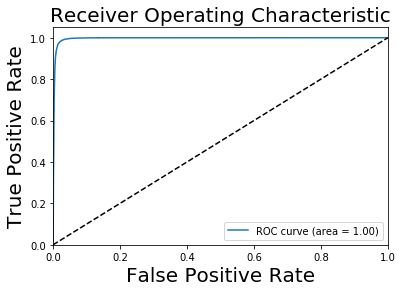

In [29]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    #fig.set_size_inches(14, 10)
    plt.tight_layout()

In [31]:
from sklearn.metrics import confusion_matrix

#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(pcValidation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

Normalized confusion matrix
[[0.01071429 0.37857143 0.61071429]
 [0.0031917  0.97083067 0.02597763]
 [0.00144413 0.00858632 0.98996955]]


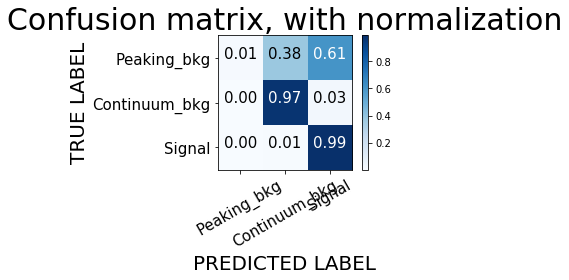

In [32]:
import itertools

plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix, with normalization')

### Store the Weights

In [33]:
Best_Model.save("Best_Model.h5")

In [34]:
Best_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4200      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


### Try Loading the model

In [35]:
!ls

Analysis.ipynb	      Keras_Analysis.ipynb		   README.md
Best_Model.h5	      Models				   Scaler.pkl
Data_Challenge.ipynb  PCA.pkl				   Tidy.ipynb
environment.yml       Pecularity_in_the_Signal_File.ipynb  Untitled.ipynb


In [36]:
from keras.models import load_model

Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 83)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                4200      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 6,903
Trainable params: 6,903
Non-trainable params: 0
_________________________________________________________________


In [37]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

66679/66679 [==============================] - 1s 14us/step


[0.009858418728025857, 0.9823932572509848]

In [38]:
Loaded_Model.predict(pcTest)

array([[1.7950326e-02, 9.5239532e-01, 5.7718128e-02],
       [8.9100003e-03, 1.0033488e-02, 9.9249840e-01],
       [4.7825783e-02, 9.7935796e-01, 2.5532722e-02],
       ...,
       [1.0134757e-02, 9.9982548e-01, 1.1560321e-04],
       [3.1518936e-03, 9.9995005e-01, 2.2619963e-05],
       [1.8974900e-02, 2.1654665e-02, 9.8362839e-01]], dtype=float32)